# Project 4: House Prices 

<center> Team: George Serge Barsukov, Stephanie Seward, & David Linnard Wheeler <center/>

<center> Fall 2019 <center/>

## Introduction

data: https://www.kaggle.com/c/house-prices-advanced-regression-techniques

## Goals

Develop multiple models, selecting the best as a business use case for predicting real estate sale price in Ames, Iowa. 

## Criteria

- Accuracy of prediction of sale price.
- MAPE optimization.

## Import libraries and data

Packages

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from io import StringIO

# Import library for preprocessing
from sklearn import preprocessing
# Imputation
from sklearn.impute import SimpleImputer
# To compare dependent variable to normal distribution
from scipy.stats import norm
# To inspect residuals
from scipy import stats

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler # for scaling
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.utils import check_array
import statsmodels.api as sm
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

# first neural network with keras tutorial
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
from keras import regularizers
from keras.layers import Dropout
import heapq

# define the keras model
from keras.layers import Dropout

import nltk

Using TensorFlow backend.


Import and shuffle data

In [2]:
# Training data using random_state for reproducable results
train_data = pd.read_csv('train.csv').sample(frac=1, random_state=1).reset_index(drop=True)
# Testing Data
test_data = pd.read_csv('test.csv').sample(frac=1, random_state=1).reset_index(drop=True)

# Delete 'Id' column- it not needed
train_data.drop("Id", axis = 1, inplace = True)
test_data.drop("Id", axis = 1, inplace = True)

## Feature engineering

**Identify quantitative vs qualitative features for training data**

- Quantitative features

In [3]:
quantitative = [f for f in train_data.columns if train_data.dtypes[f] != 'object']
# len(quantitative), quantitative

- Summarize

In [4]:
train_data[quantitative].describe()
#for col in train_data[quantitative].columns:
#    print(col)

MSSubClass  LotFrontage        LotArea  OverallQual  OverallCond  \
count  1460.000000  1201.000000    1460.000000  1460.000000  1460.000000   
mean     56.897260    70.049958   10516.828082     6.099315     5.575342   
std      42.300571    24.284752    9981.264932     1.382997     1.112799   
min      20.000000    21.000000    1300.000000     1.000000     1.000000   
25%      20.000000    59.000000    7553.500000     5.000000     5.000000   
50%      50.000000    69.000000    9478.500000     6.000000     5.000000   
75%      70.000000    80.000000   11601.500000     7.000000     6.000000   
max     190.000000   313.000000  215245.000000    10.000000     9.000000   

         YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1   BsmtFinSF2  ...  \
count  1460.000000   1460.000000  1452.000000  1460.000000  1460.000000  ...   
mean   1971.267808   1984.865753   103.685262   443.639726    46.549315  ...   
std      30.202904     20.645407   181.066207   456.098091   161.319273  ...   
min    1872.000000   1950.000000     0.000000     0.000000     0.000000  ...   
25%    1954.000000   1967.000000     0.000000     0.000000     0.000000  ...   
50%    1973.000000   1994.000000     0.000000   383.500000     0.000000  ...   
75%    2000.000000   2004.000000   166.000000   712.250000     0.000000  ...   
max    2010.000000   2010.000000  1600.000000  5644.000000  1474.000000  ...   

        WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  ScreenPorch  \
count  1460.000000  1460.000000    1460.000000  1460.000000  1460.000000   
mean     94.244521    46.660274      21.954110     3.409589    15.060959   
std     125.338794    66.256028      61.119149    29.317331    55.757415   
min       0.000000     0.000000       0.000000     0.000000     0.000000   
25%       0.000000     0.000000       0.000000     0.000000     0.000000   
50%       0.000000    25.000000       0.000000     0.000000     0.000000   
75%     168.000000    68.000000       0.000000     0.000000     0.000000   
max     857.000000   547.000000     552.000000   508.000000   480.000000   

          PoolArea       MiscVal       MoSold       YrSold      SalePrice  
count  1460.000000   1460.000000  1460.000000  1460.000000    1460.000000  
mean      2.758904     43.489041     6.321918  2007.815753  180921.195890  
std      40.177307    496.123024     2.703626     1.328095   79442.502883  
min       0.000000      0.000000     1.000000  2006.000000   34900.000000  
25%       0.000000      0.000000     5.000000  2007.000000  129975.000000  
50%       0.000000      0.000000     6.000000  2008.000000  163000.000000  
75%       0.000000      0.000000     8.000000  2009.000000  214000.000000  
max     738.000000  15500.000000    12.000000  2010.000000  755000.000000  

[8 rows x 37 columns]

- Qualitative features

In [5]:
qualitative = [f for f in train_data.columns if train_data.dtypes[f] == 'object']
# len(qualitative), qualitative

- Summarize

In [6]:
train_data[qualitative].describe()
#for col in train_data[qualitative].columns:
#    print(col)

MSZoning Street Alley LotShape LandContour Utilities LotConfig  \
count      1460   1460    91     1460        1460      1460      1460   
unique        5      2     2        4           4         2         5   
top          RL   Pave  Grvl      Reg         Lvl    AllPub    Inside   
freq       1151   1454    50      925        1311      1459      1052   

       LandSlope Neighborhood Condition1  ... GarageType GarageFinish  \
count       1460         1460       1460  ...       1379         1379   
unique         3           25          9  ...          6            3   
top          Gtl        NAmes       Norm  ...     Attchd          Unf   
freq        1382          225       1260  ...        870          605   

       GarageQual GarageCond PavedDrive PoolQC  Fence MiscFeature SaleType  \
count        1379       1379       1460      7    281          54     1460   
unique          5          5          3      3      4           4        9   
top            TA         TA          Y     Gd  MnPrv        Shed       WD   
freq         1311       1326       1340      3    157          49     1267   

       SaleCondition  
count           1460  
unique             6  
top           Normal  
freq            1198  

[4 rows x 43 columns]

In [7]:
QualTrainData = train_data[qualitative]

In [8]:
# ref. https://github.com/shan4224/Kaggle_House_Prices
n = QualTrainData
for c in n.columns:
    print('{:<14}'.format(c),
          QualTrainData[c].unique())

MSZoning       ['RL' 'RM' 'FV' 'RH' 'C (all)']
Street         ['Pave' 'Grvl']
Alley          [nan 'Pave' 'Grvl']
LotShape       ['Reg' 'IR1' 'IR2' 'IR3']
LandContour    ['Lvl' 'Bnk' 'Low' 'HLS']
Utilities      ['AllPub' 'NoSeWa']
LotConfig      ['Inside' 'FR2' 'Corner' 'FR3' 'CulDSac']
LandSlope      ['Gtl' 'Mod' 'Sev']
Neighborhood   ['CollgCr' 'SWISU' 'Sawyer' 'MeadowV' 'NAmes' 'NridgHt' 'Somerst'
 'SawyerW' 'NWAmes' 'Edwards' 'Blmngtn' 'Veenker' 'OldTown' 'ClearCr'
 'StoneBr' 'BrkSide' 'BrDale' 'IDOTRR' 'Gilbert' 'NoRidge' 'Mitchel'
 'Crawfor' 'Timber' 'Blueste' 'NPkVill']
Condition1     ['Norm' 'RRNn' 'RRAe' 'PosN' 'Feedr' 'RRAn' 'Artery' 'PosA' 'RRNe']
Condition2     ['Norm' 'Feedr' 'RRAn' 'PosN' 'Artery' 'RRNn' 'RRAe' 'PosA']
BldgType       ['1Fam' 'Twnhs' 'TwnhsE' '2fmCon' 'Duplex']
HouseStyle     ['2Story' '2.5Fin' '1Story' 'SFoyer' 'SLvl' '1.5Fin' '1.5Unf' '2.5Unf']
RoofStyle      ['Gable' 'Hip' 'Shed' 'Flat' 'Gambrel' 'Mansard']
RoofMatl       ['CompShg' 'WdShngl' 'WdShake' '

**Standardize feature (not response) data with Z-score so features share a common scale**

$z = \frac{x_i - \mu}{\sigma}$

Train data

In [9]:
# The Scaler object
scaler = preprocessing.StandardScaler()
# Scale
scaled_train_data = scaler.fit_transform(train_data[quantitative].loc[:,
                             train_data[quantitative].columns != 'SalePrice'])
scaled_train_data = pd.DataFrame(scaled_train_data,
                                 columns=train_data[quantitative].loc[:,
                             train_data[quantitative].columns != 'SalePrice'].columns)

- Add SalePrice back to dataframe

In [10]:
scaled_train_data['SalePrice'] = train_data.SalePrice

- Add qualitative features back to dataframe

In [11]:
TrainData = pd.concat([scaled_train_data, train_data[qualitative]],
                axis=1)

> Sanity check

In [12]:
TrainData.shape == train_data.shape

True

**Are there any missing data?**

Subset missing values

In [13]:
# Frequency of missing data
MIA = TrainData.isnull().sum()/len(TrainData)
# Grab only data with missing values
MIA = MIA[MIA > 0]
# Sort
MIA.sort_values(inplace=True)
# Inspect
MIA

Electrical      0.000685
MasVnrArea      0.005479
MasVnrType      0.005479
BsmtQual        0.025342
BsmtCond        0.025342
BsmtFinType1    0.025342
BsmtFinType2    0.026027
BsmtExposure    0.026027
GarageYrBlt     0.055479
GarageCond      0.055479
GarageQual      0.055479
GarageFinish    0.055479
GarageType      0.055479
LotFrontage     0.177397
FireplaceQu     0.472603
Fence           0.807534
Alley           0.937671
MiscFeature     0.963014
PoolQC          0.995205
dtype: float64

Plot missing values

In [14]:
# Convert to dataframe
MIA = MIA.to_frame()
# Rename columns
MIA.columns = ['Frequency']
MIA.index.names = ['Feature']
MIA['Feature'] = MIA.index

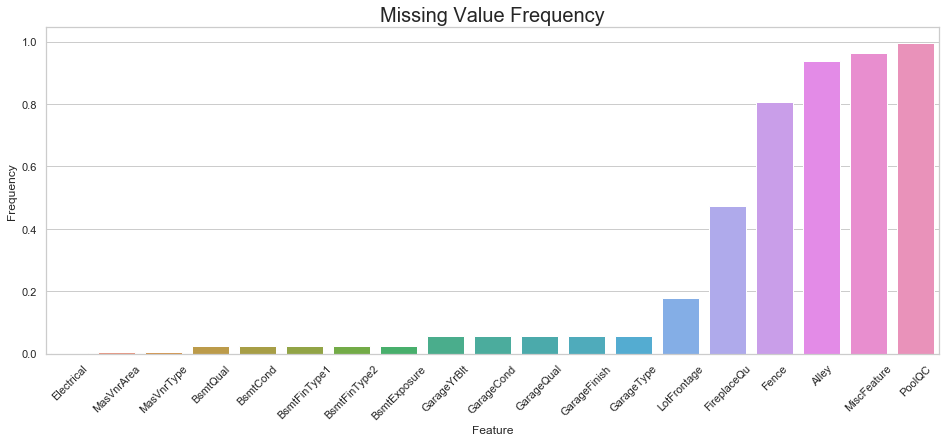

In [15]:
# Plot
sns.set(style="whitegrid",
        color_codes=True)
plt.figure(figsize=(16, 6))
plt.title("Missing Value Frequency", fontsize=20)
p = sns.barplot(x = 'Feature',
                y = 'Frequency',
                data=MIA)
p.set_xticklabels(p.get_xticklabels(),
                  rotation=45);

We noticed here from the documentation that NA values for POOLQC, MiscFeature, Alley, Fence, FirefaceQual, GarageFinish, GarageCond,GarageYrBlt, BsmtExposure, BsmtFinType1, BsmtFinType2, BsmtCond, BsmtQual, MasVnrType, MasVnrArea and GarageType were not missing values. Instead, they were place holders for None, as in no alley, pool, garage.  The same was true for the Bsmt Variables. As such, we did not impute these values and replaced the .nan values with none.

### Imputation

Train Data

- Quantitative features

In [16]:
Imputer_Quant = SimpleImputer(missing_values=np.nan, strategy='mean')
Imputed_TrainData_Quant = Imputer_Quant.fit_transform(scaled_train_data)
# Convert to DataFrame
Imputed_TrainData_Quant = pd.DataFrame(Imputed_TrainData_Quant)
# Replace columns labels
Imputed_TrainData_Quant.columns = scaled_train_data.columns

- Qualitative features

In [17]:
train_data.PoolQC.fillna('none', axis = 0, inplace=True)
train_data.MiscFeature.fillna('none', axis = 0, inplace=True)
train_data.Alley.fillna('none', axis = 0, inplace=True)
train_data.Fence.fillna('none', axis = 0, inplace=True)
train_data.FireplaceQu.fillna('none', axis = 0, inplace=True)
train_data.GarageType.fillna('none', axis = 0, inplace=True)
train_data.GarageFinish.fillna('none', axis = 0, inplace=True)
train_data.GarageCond.fillna('none', axis = 0, inplace=True)
train_data.GarageYrBlt.fillna('none', axis = 0, inplace=True)
train_data.BsmtExposure.fillna('none', axis = 0, inplace=True)
train_data.BsmtFinType1.fillna('none', axis = 0, inplace=True)
train_data.BsmtFinType2.fillna('none', axis = 0, inplace=True)
train_data.BsmtCond.fillna('none', axis = 0, inplace=True)
train_data.BsmtQual.fillna('none', axis = 0, inplace=True)

In [18]:
Imputer_Qual = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
Imputed_TrainData_Qual = Imputer_Qual.fit_transform(train_data[qualitative])
# Convert to DataFrame
Imputed_TrainData_Qual = pd.DataFrame(Imputed_TrainData_Qual, columns=qualitative)

Combine imputed dataframes

In [19]:
ImputedTrainData = pd.concat([Imputed_TrainData_Quant, Imputed_TrainData_Qual],
                axis=1)

Sanity Checks

In [20]:
# Frequency of missing data
MIA = ImputedTrainData.isnull().sum()/len(ImputedTrainData)
# Grab only data with missing values
MIA = MIA[MIA > 0]
# Inspect
len(MIA)

0

## Outlier removal

Dependent/response variable: sale price

- Histogram with normal for comparison

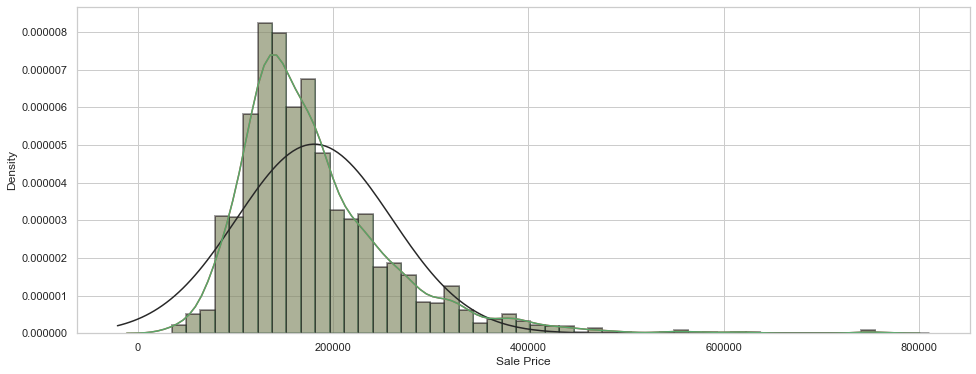

In [21]:
plt.figure(figsize=(16, 6))
# Plot Histogram for 'SalePrice'
ax = sns.distplot(ImputedTrainData['SalePrice'],
            fit=norm,
            hist=True,
            color='r',hist_kws=dict(edgecolor="k", linewidth=2))
ax = sns.distplot(ImputedTrainData['SalePrice'],
            hist=True,
            color='g',hist_kws=dict(edgecolor="k", linewidth=1))
ax.set(xlabel='Sale Price',
       ylabel='Density')
plt.show();

> - Peakedness/kurtosis

In [22]:
ImputedTrainData['SalePrice'].kurt()

6.536281860064527

> - Skewness

In [23]:
ImputedTrainData['SalePrice'].skew()

1.8828757597682129

Residuals

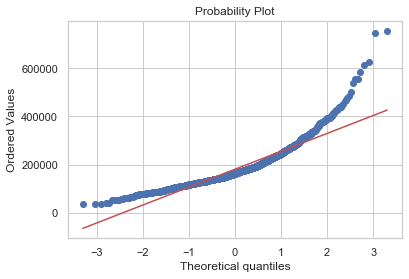

In [24]:
stats.probplot(ImputedTrainData['SalePrice'],
            plot = plt);

Bivariate relationships between sale price and selected features

In [25]:
cols = list(scaled_train_data.columns).copy()
cols.remove('SalePrice')

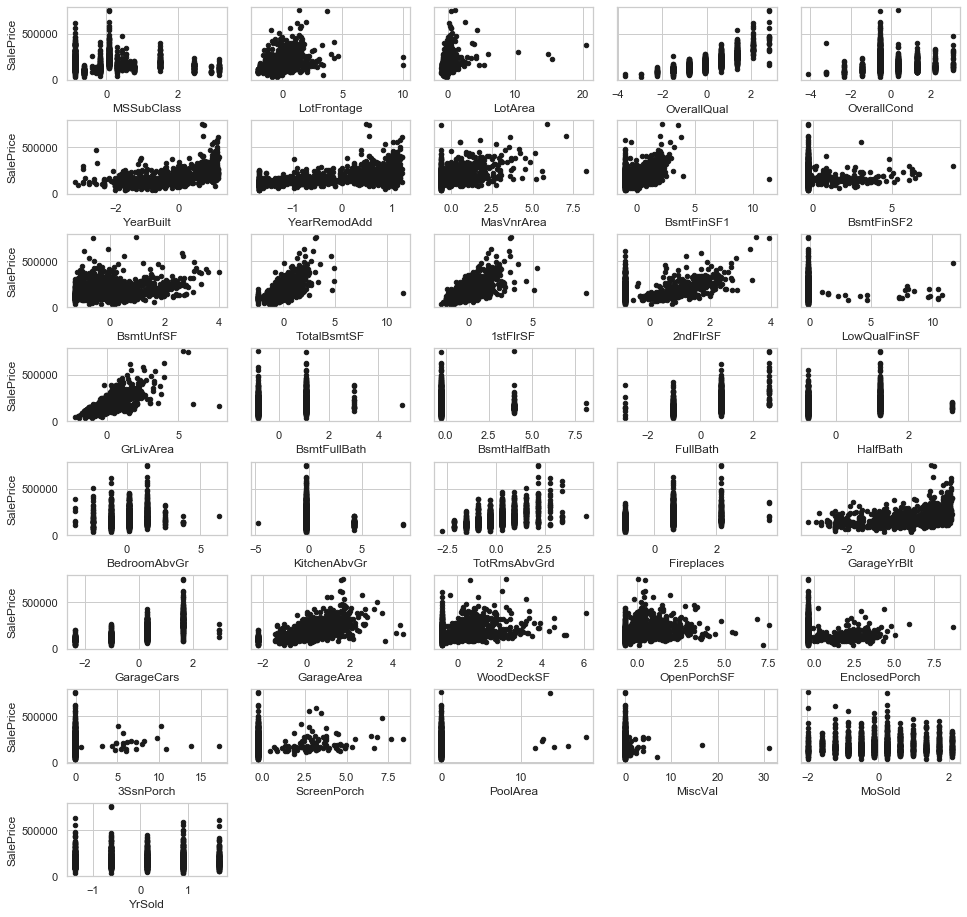

In [26]:
# Figure and axes
ncols = 5 
nrows = 8
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(16, 16))
# Spaces between
fig.subplots_adjust(wspace=0.15, 
                    hspace=0.55)
# Unravel
axs = np.ravel(axs)
# For each plot
for i, c in zip(range(len(scaled_train_data.columns)), cols):
    # Plot
    ImputedTrainData.plot.scatter(ax=axs[i],
                                  x=c,
                                  y='SalePrice',
                                  sharey=True,
                                  colorbar=False,
                                  c='k')
for i in range(len(cols), ncols*nrows):
    fig.delaxes(axs[i])    

Remove outliers

- Define outliers as observations that exceed 1.5 times the interquartile range from both the first and third quartiles.

In [27]:
# Define function to remove outliers
def OutlierRemover(df, col):
#     # for each column
#     for col in cols:
    # first quartile
    q1 = df[col].quantile(0.25)
    # third quartile
    q3 = df[col].quantile(0.75)
    # Interquartile range
    IQR = q3 - q1
    # Lower bound
    lower_bound  = q1 - (1.5  * IQR)
    # Upprer bound
    upper_bound = q3 + (1.5 * IQR)
    # Df with outliers removed
    out_df = df.loc[(df[col] > lower_bound) & (df[col] < upper_bound)]
    # Return df with outliers removed
    return out_df
# Define train data with imputed values and no "outliers" as
ProcessedTrainData = OutlierRemover(ImputedTrainData,
                                    'SalePrice')
# Define train data without imputed values and no "outliers" as
TrainData = OutlierRemover(TrainData,
                                    'SalePrice')
#                                     ImputedTrainData[scaled_train_data.columns].columns)

> adapted from: https://hackernoon.com/predicting-the-price-of-houses-in-brooklyn-using-python-1abd7997083b

Sanity Checks

- Imputed data with outliers removed

In [28]:
ProcessedTrainData.shape

(1399, 80)

- Non-imputed data with outliers removed

In [29]:
TrainData.shape

(1399, 80)

In [30]:
ProcessedTrainData.shape < ImputedTrainData.shape

True

Bivariate relationships

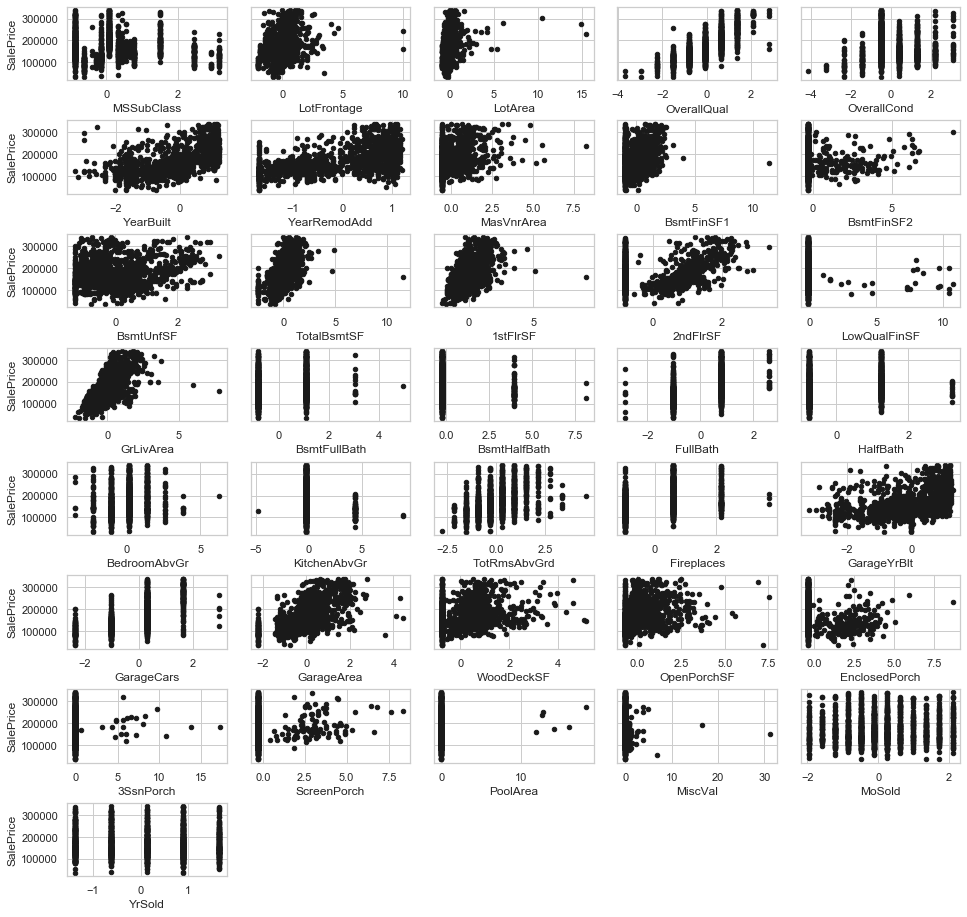

In [31]:
# Figure and axes
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(16, 16))
# Spaces between
fig.subplots_adjust(wspace=0.15, 
                    hspace=0.55)
# Unravel
axs = np.ravel(axs)
# For each plot
for i, c in zip(range(37), cols):
    # Plot
    ProcessedTrainData.plot.scatter(ax=axs[i],
                                  x=c,
                                  y='SalePrice',
                                  sharey=True,
                                  colorbar=False,
                                  c='k')
for i in range(len(cols), ncols*nrows):
    fig.delaxes(axs[i]) 

## Exploratory Data Analysis

Quantitative/numerical features

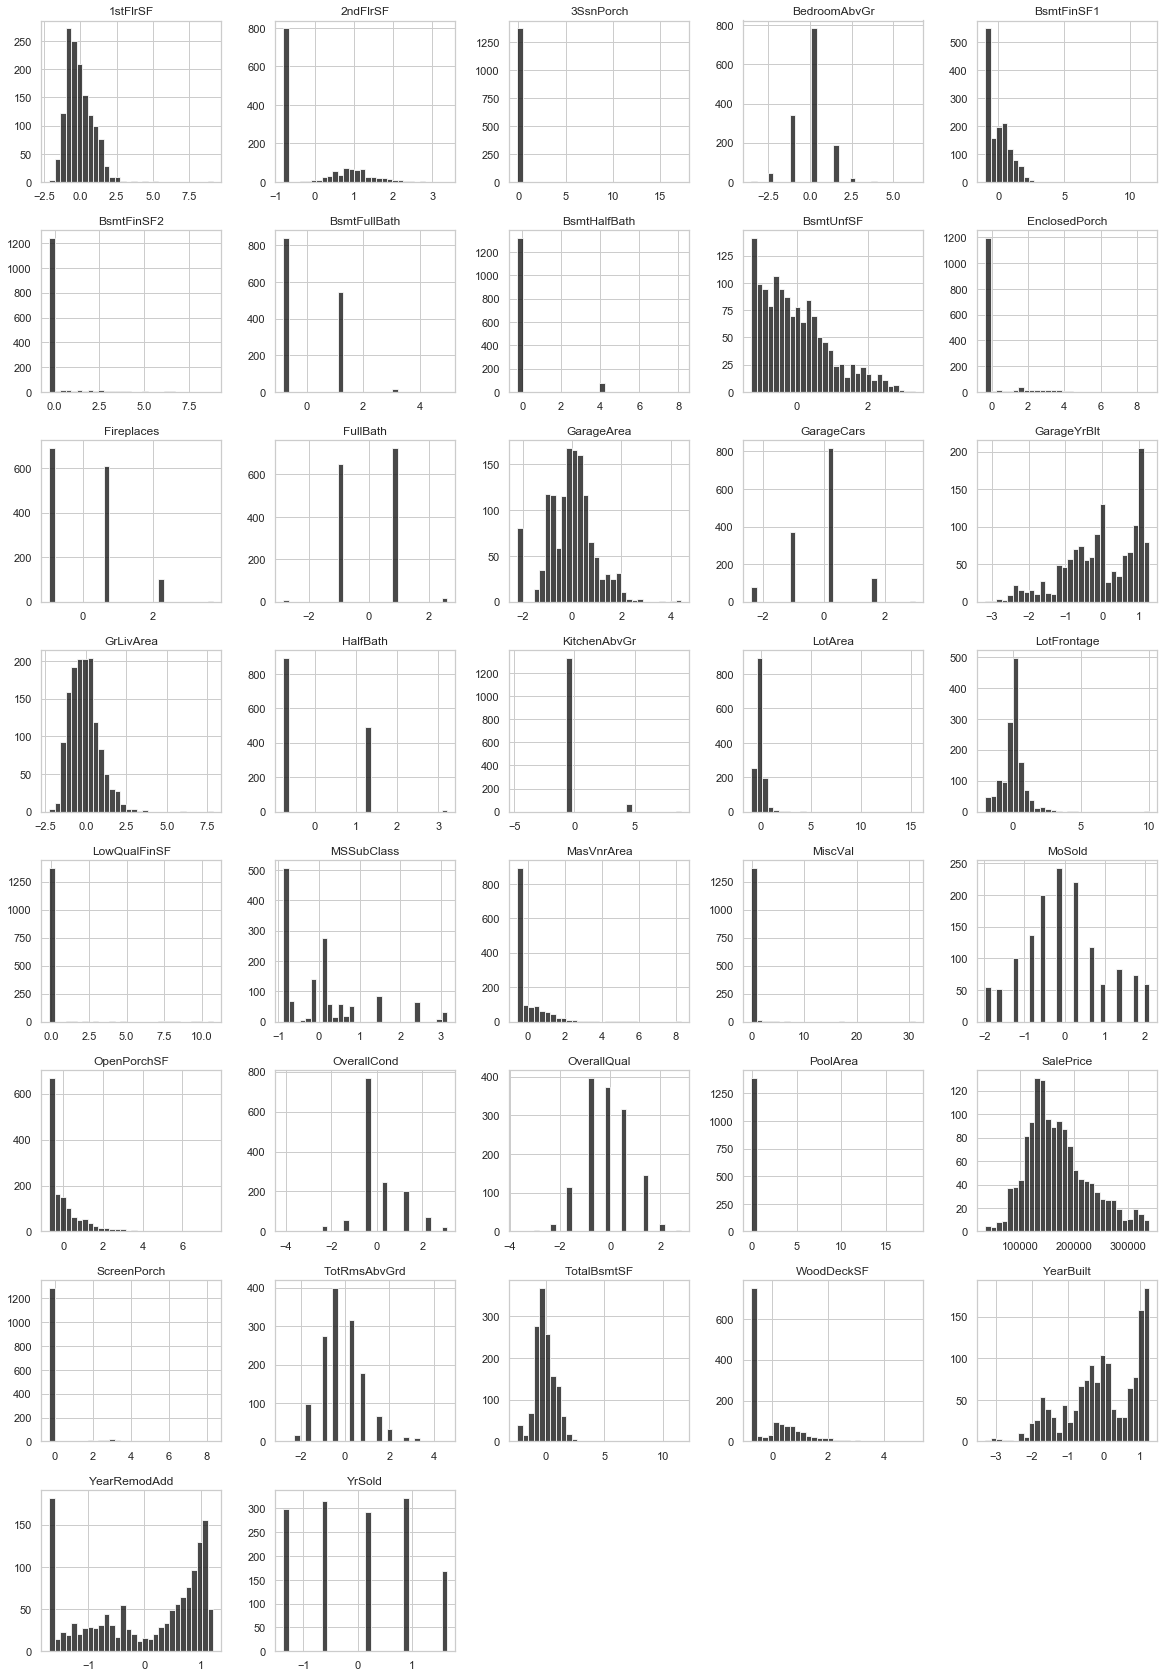

In [32]:
ProcessedTrainData.hist(layout=(8,5),
                        color='k',
                        alpha=0.8,
                        bins=30,
                        figsize=(20,30));

Categorical features

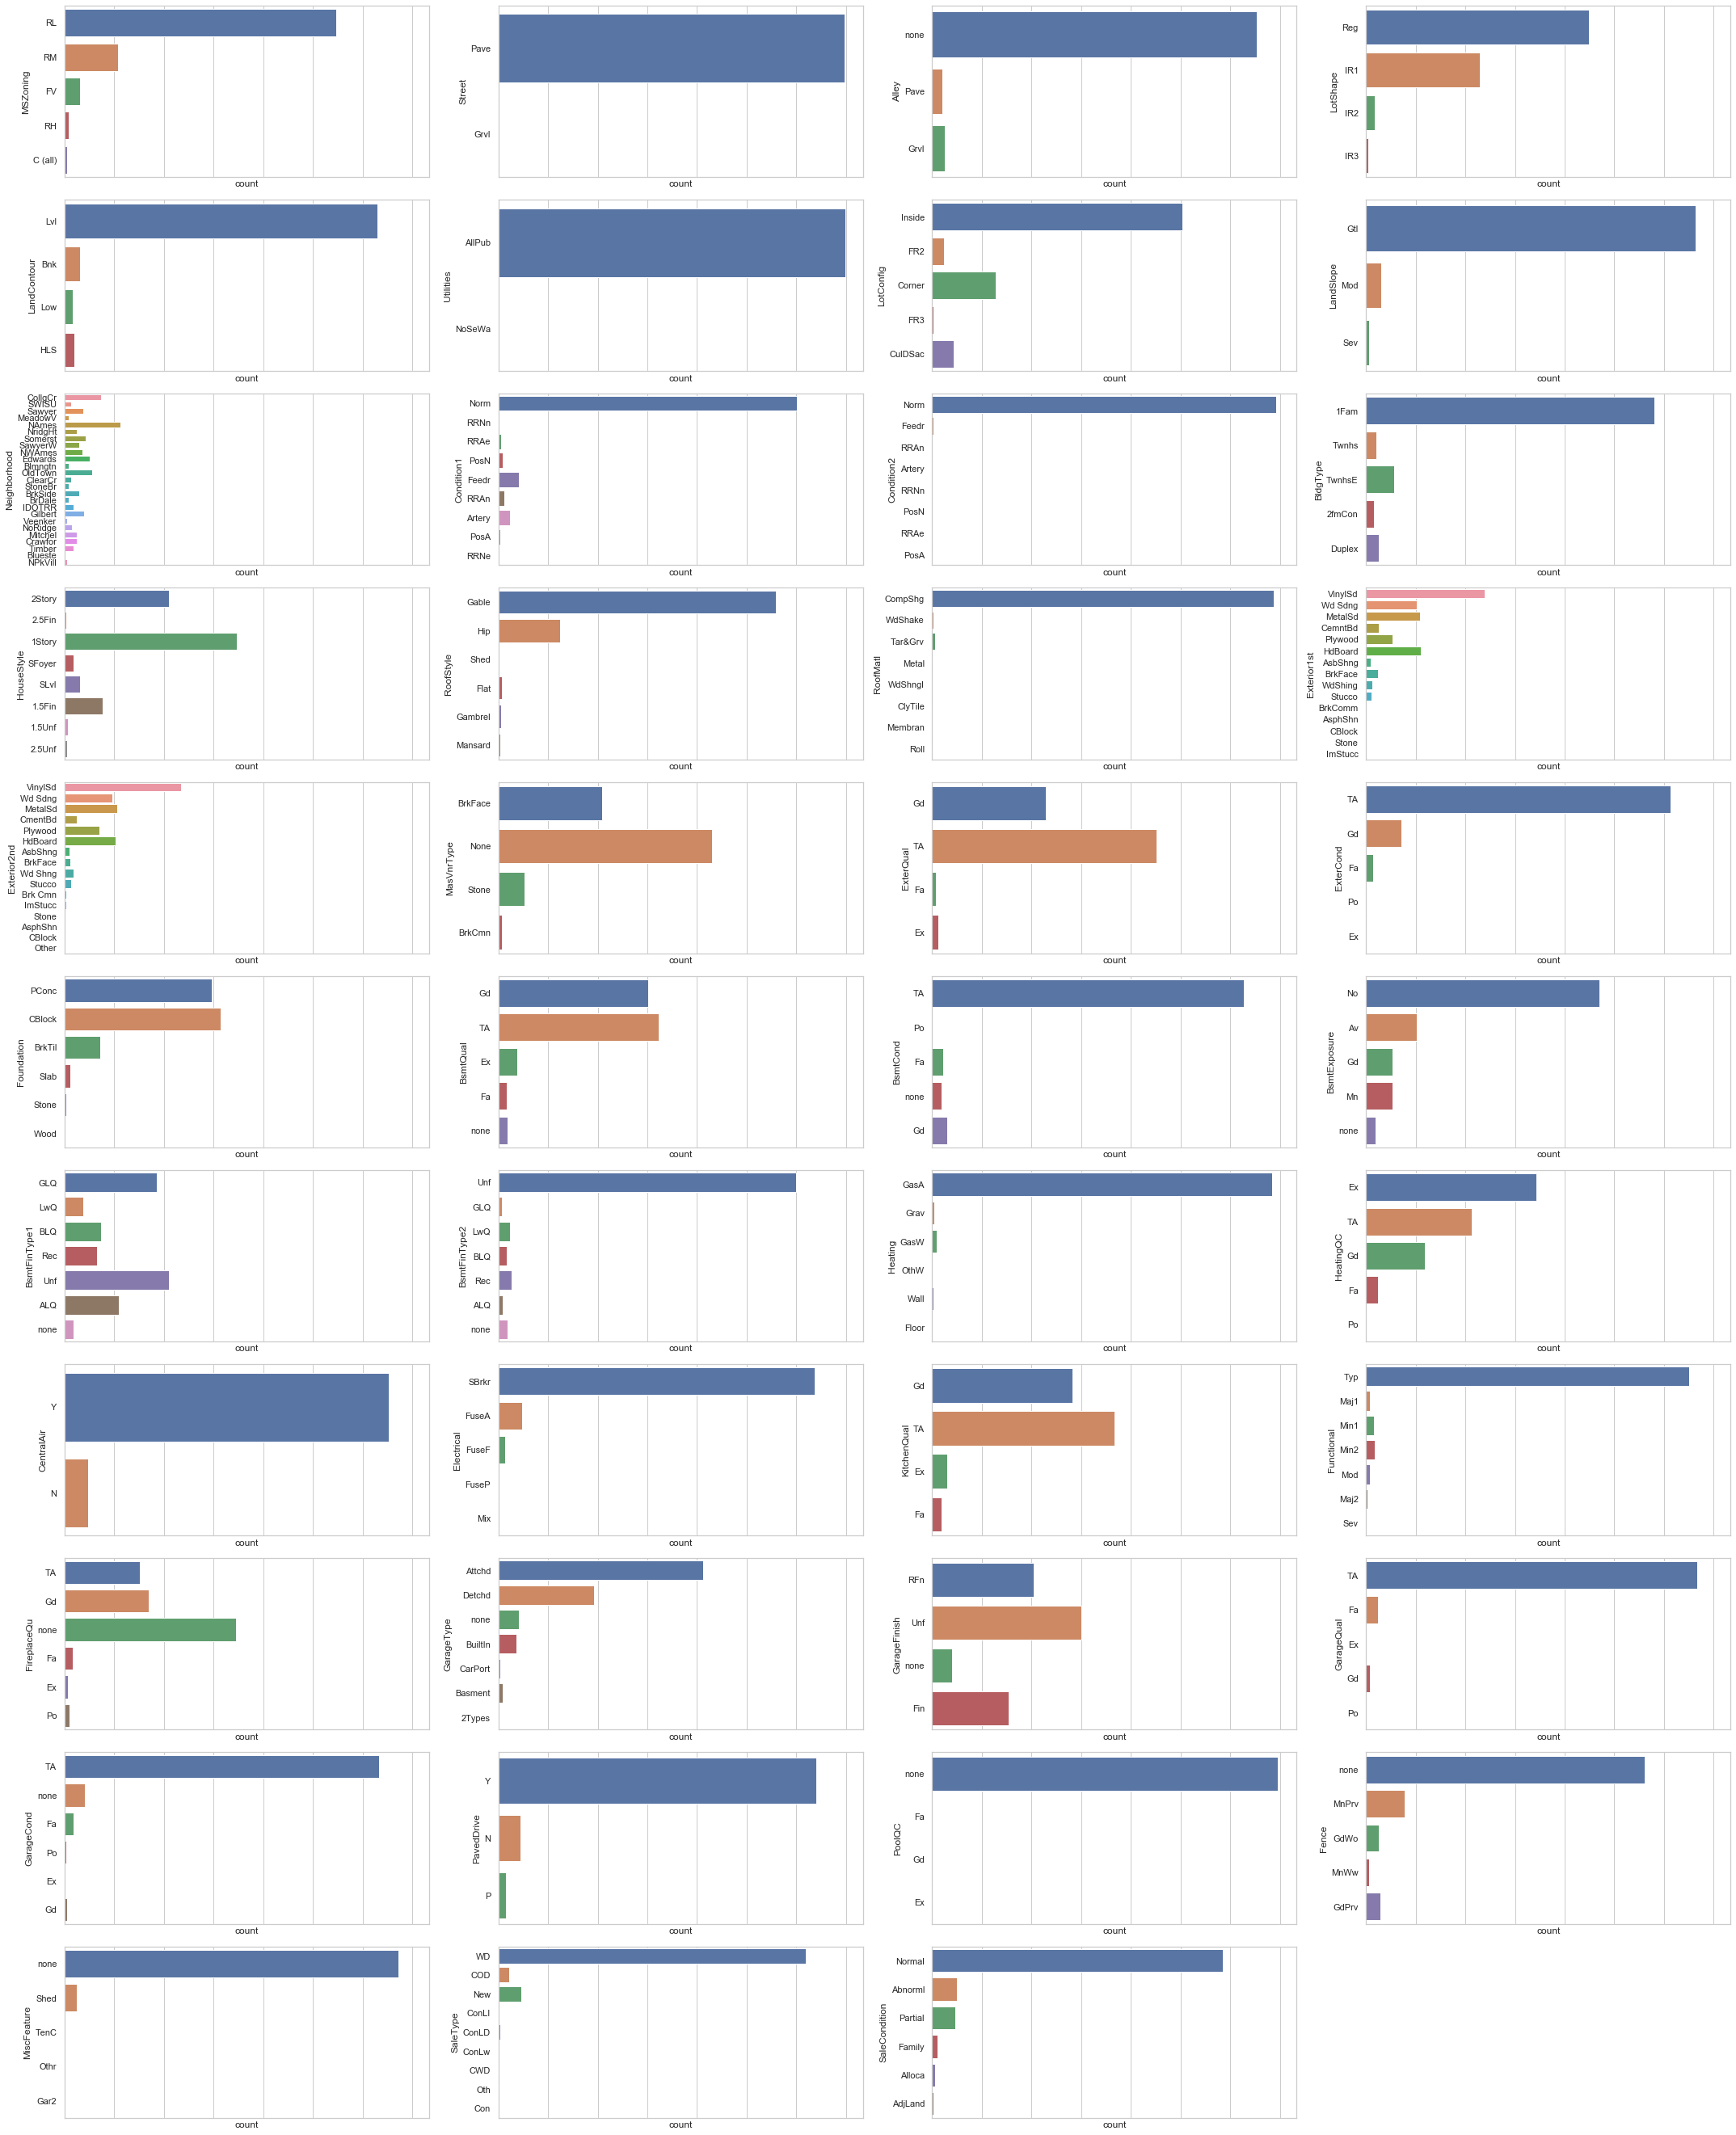

In [33]:
# Plot bar plot for each categorical feature
fig, axes =plt.subplots(12,4, figsize=(30,40), sharex=True)
axes = axes.flatten()
# Unravel
axes = np.ravel(axes)
object_bol = ProcessedTrainData.dtypes == 'object'
for ax, catplot in zip(axes, ProcessedTrainData.dtypes[object_bol].index):
    sns.countplot(y=catplot, data=ProcessedTrainData, ax=ax)
    
# Remove extra plots
for i in range(len(ProcessedTrainData[qualitative].columns), 4*12):
    fig.delaxes(axes[i])

plt.tight_layout()   
plt.show()

**Are there linear correlations between the quantitative variables?**

Inspect linear relationships between response and quantitative features

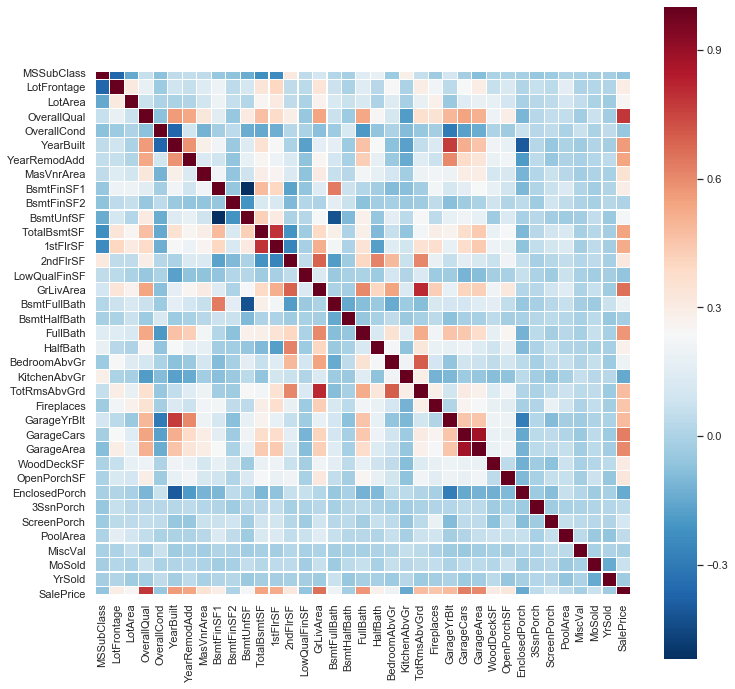

In [34]:
# Generate correlation matrix and plot
f, ax = plt.subplots(figsize=(12, 12))
# Plot
sns.heatmap(ProcessedTrainData[quantitative].corr(),
            linewidths=0.1,
            vmax=1.0,
            square=True,
            annot=False,
            cmap="RdBu_r");

Linear relationships between sale price and top 20 features

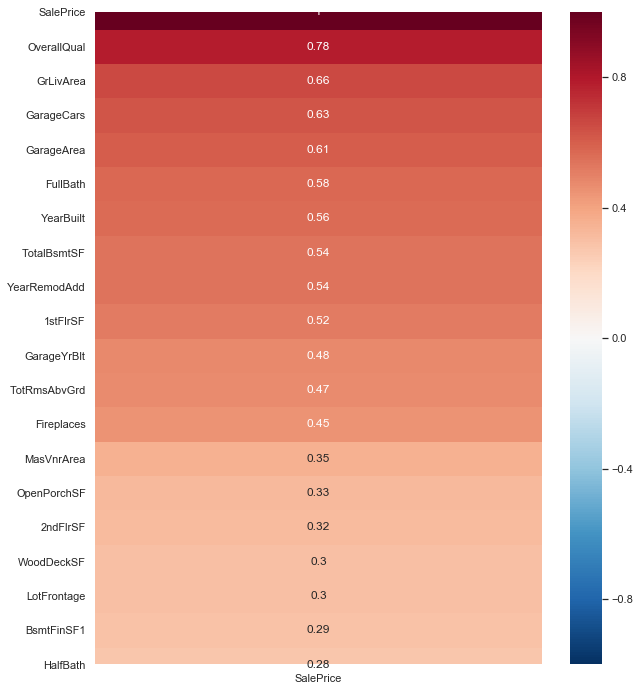

In [35]:
fig, ax = plt.subplots(figsize=(10,12))
sns.heatmap(ProcessedTrainData[quantitative].corr()[['SalePrice']].sort_values('SalePrice').tail(20),
 vmax=1, vmin=-1, cmap="RdBu_r", annot=True, ax=ax);
ax.invert_yaxis()

Relationship between sale price and top 10 most correlated features

In [36]:
CorrFeatures = ProcessedTrainData[quantitative].corr()[['SalePrice']].sort_values('SalePrice').tail(10)

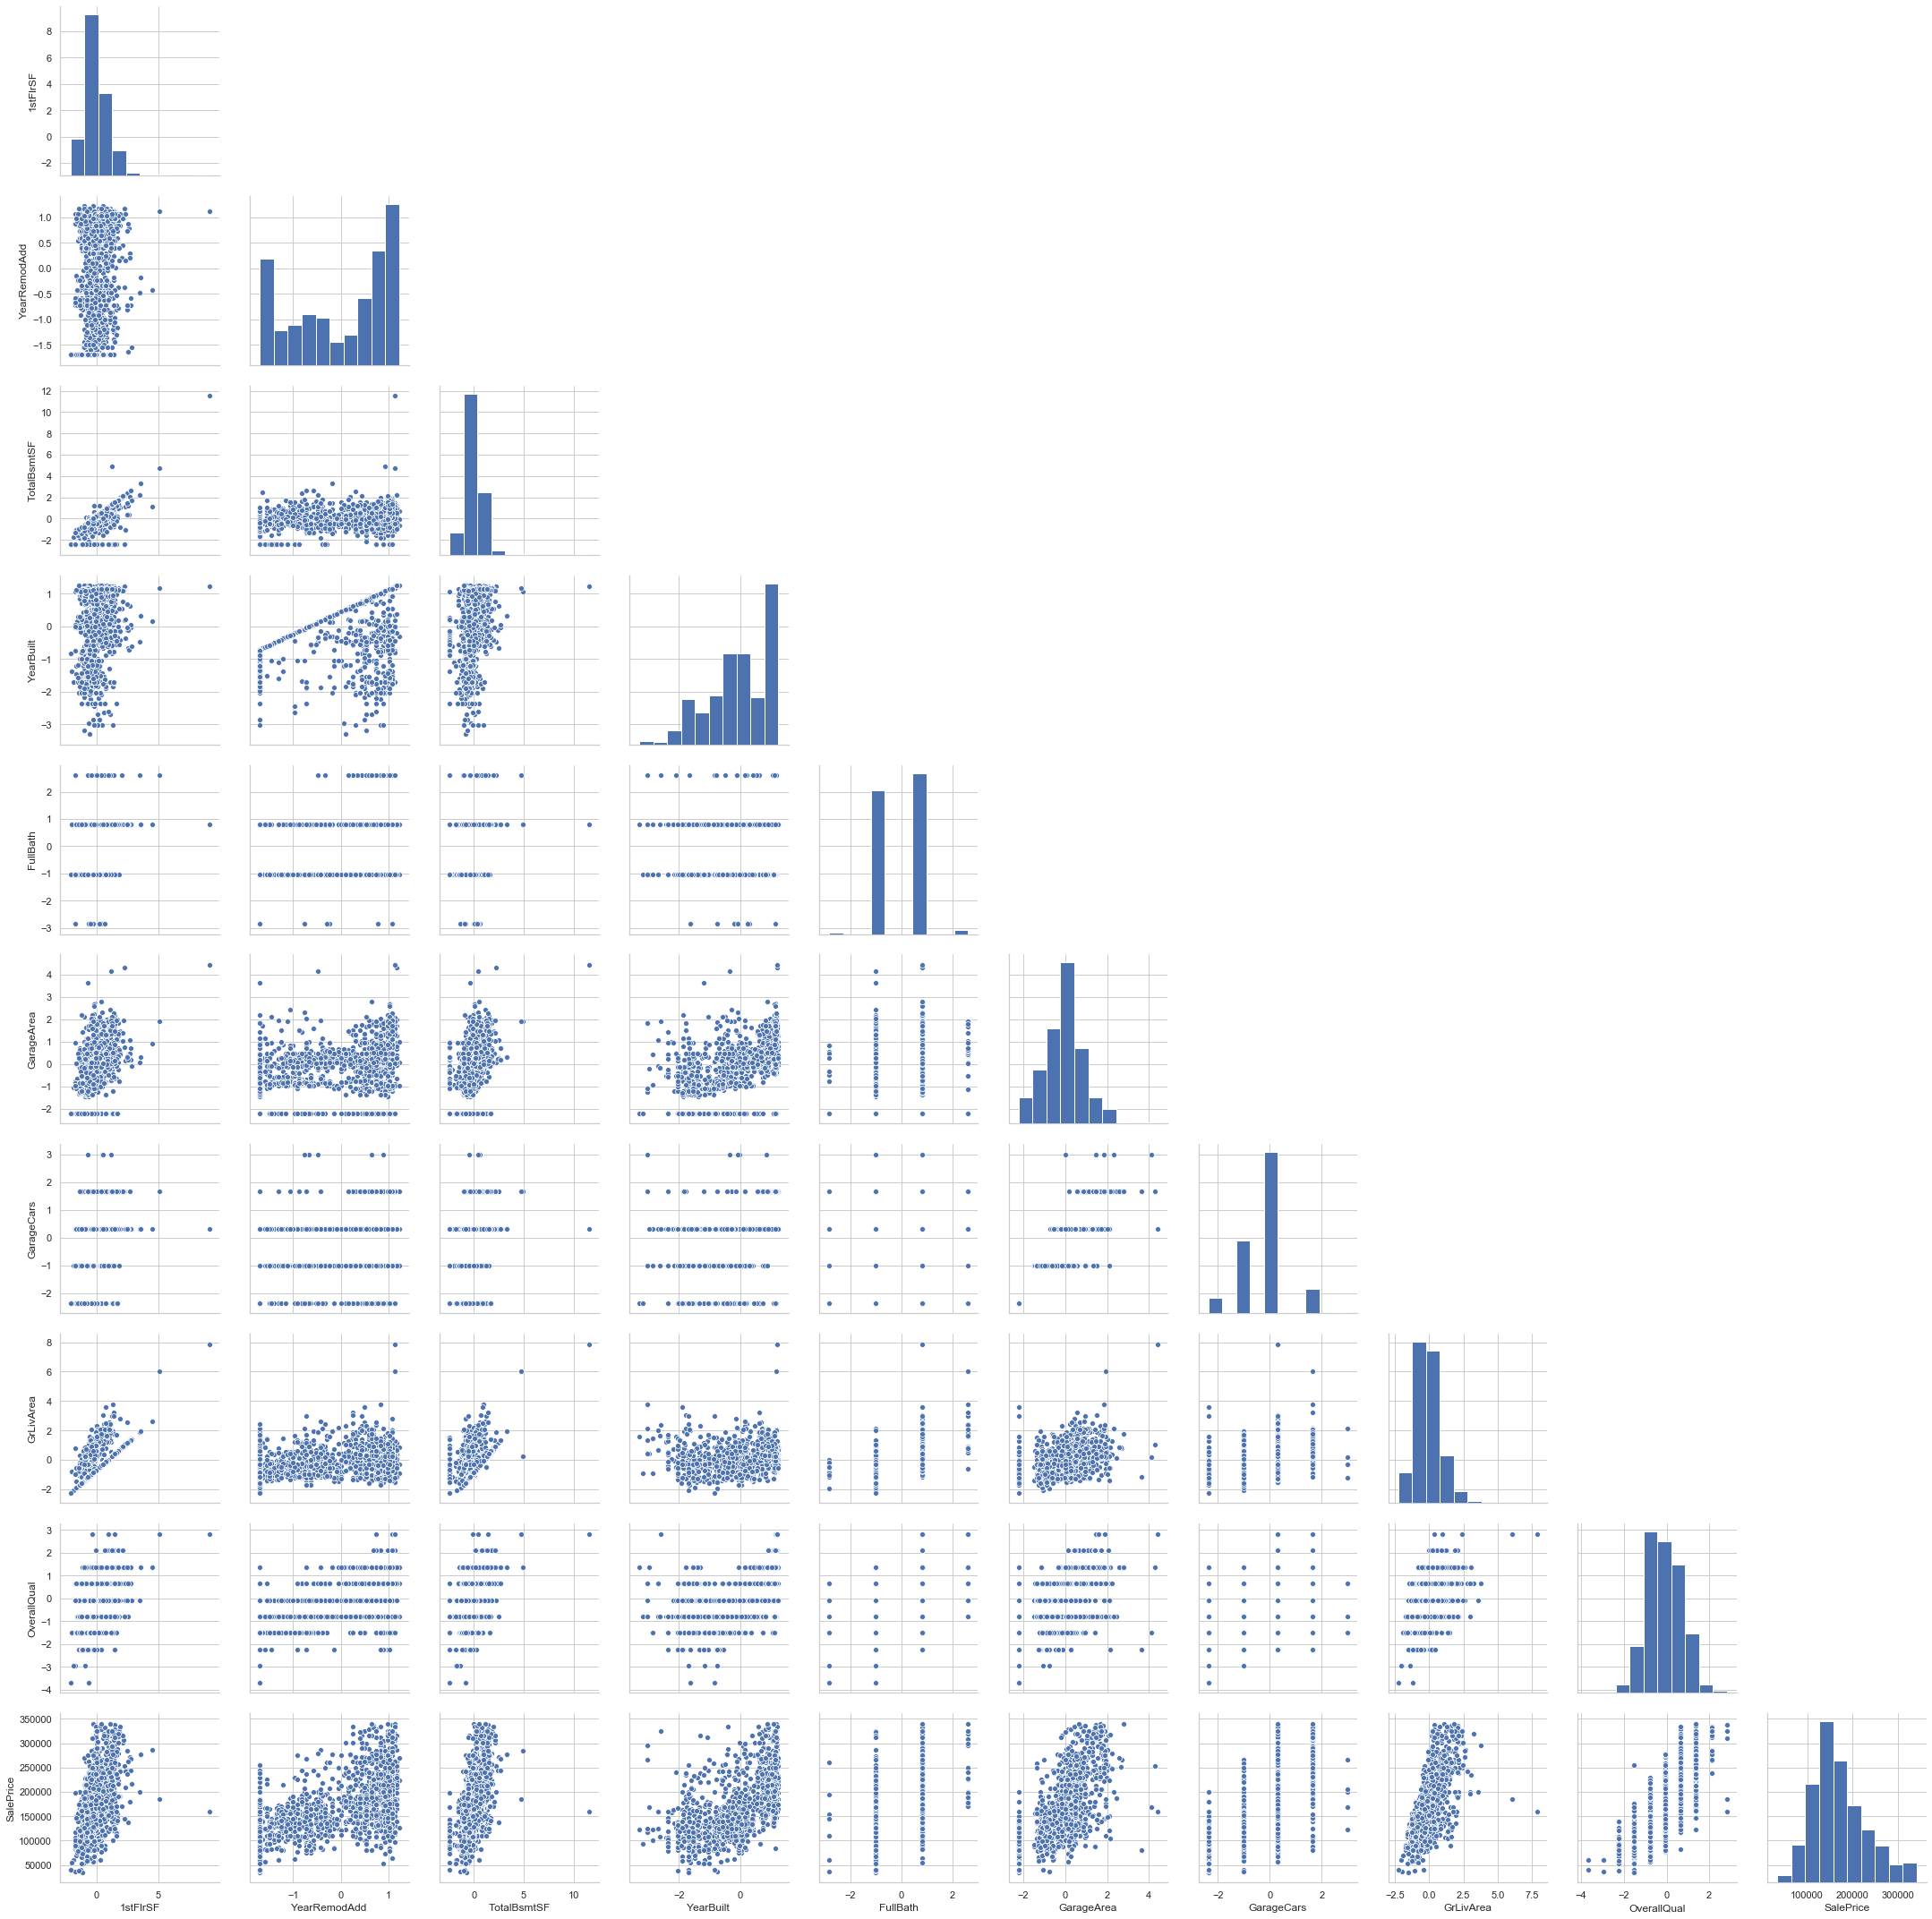

In [37]:
p = sns.pairplot(ProcessedTrainData.loc[:,CorrFeatures.index],
             height = 3);
for i, j in zip(*np.triu_indices_from(p.axes, 1)):
    p.axes[i, j].set_visible(False)

Relationship between sale price and categorical features

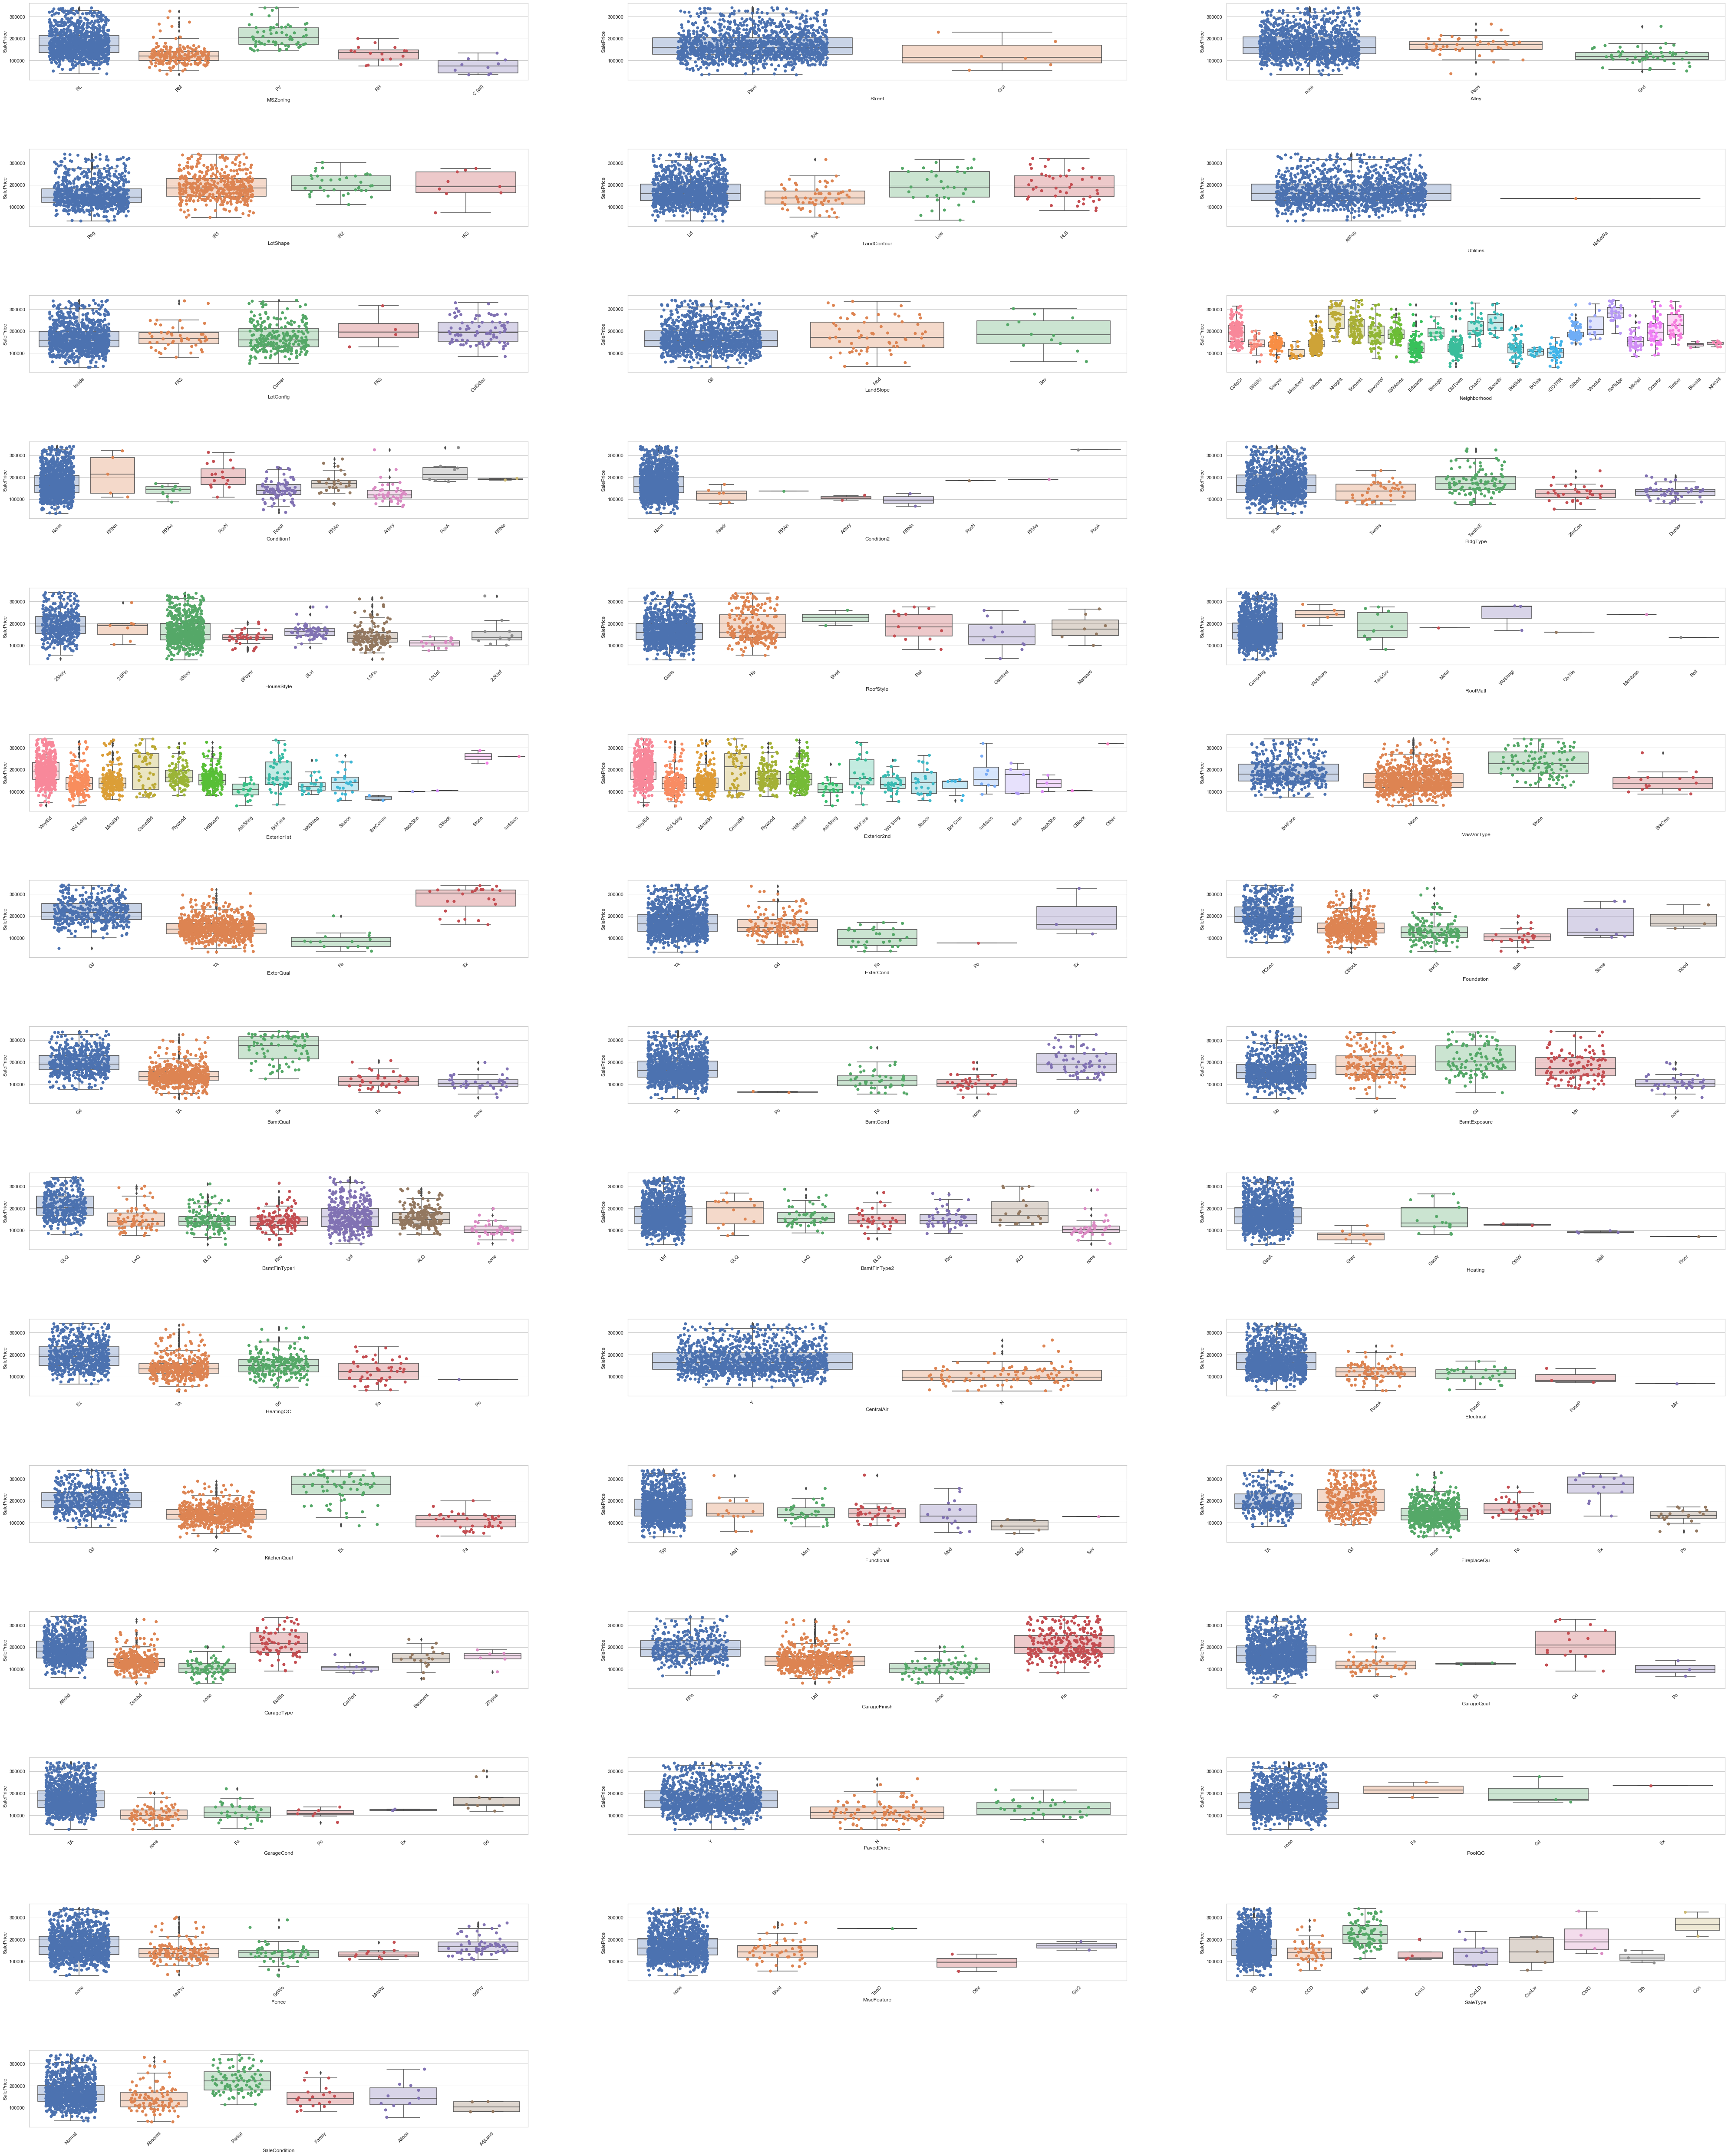

In [38]:
fig, ax = plt.subplots(15, 3, figsize=(70,90))
# Flatten
ax = ax.flatten()
# Unravel
ax = np.ravel(ax)
# Spaces between
fig.subplots_adjust(wspace=0.2, 
                    hspace=0.9)
# Unravel
for feature, subplot in zip(ProcessedTrainData[qualitative], ax.flatten()):
    # Format
    sns.set(style="whitegrid",
            color_codes=True,
            font_scale = 2)
# #     # Figure size
#      plt.figure(figsize=(16, 6))
# #     # Title
#      plt.title("Sale price of homes vs neighborhood", fontsize=20) # the "+ feature" syntax generated an error
# #     # Boxplot
    p = sns.boxplot(x = feature,
                y = 'SalePrice', saturation=1,
                data=ProcessedTrainData, ax=subplot)

    # Reduce opacity
    for patch in p.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .3))

    # Add jittered observations
    p = sns.stripplot(x = feature,
                  y = 'SalePrice',
                  data=ProcessedTrainData,
                  jitter=0.3, size=7,ax=subplot)

    # Rotate x-axis labels
    p.set_xticklabels(p.get_xticklabels(),
                  rotation=45);
    
# Remove extra plots
for i in range(len(ProcessedTrainData[qualitative].columns), 3*15):
    fig.delaxes(ax[i])

## Feature selection

### Feature selection for Multiple Linear Regression

Convert qualitative/categorical features to dummy variables

In [39]:
dummies = pd.get_dummies(ProcessedTrainData)

- Inspect dimensions

In [40]:
dummies.shape

(1399, 302)

Extract training features

In [41]:
train_x = dummies[[x for x in dummies.columns if x != 'SalePrice']]

Extract response

In [42]:
train_y = ProcessedTrainData[['SalePrice']]

Add features and response together for correlations

In [43]:
train_xy = pd.concat([train_x, train_y],
                axis=1)

**Select features that explain most of the variance with PCA**

PCA with a range of k values

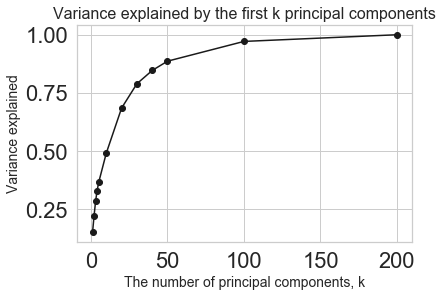

In [44]:
# K values
K = [1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 100, 200]
# PCA objects
PCAs = []
# Variance explained
VarExp = []

# For each value of K
for k in K: 
    # Reduce dimensionality from 126 to 2 
    pca = PCA(n_components=k)
    # Construct PCA, apply reduction
    PCAs.append(pca.fit_transform(train_x))
    # Variance explained
    VarExp.append(pca.explained_variance_ratio_)

    
########################
# 3. Plot fraction of variance explained by principal components
'''Show what fraction of the total variance in the training data
is explained by the first k principal components,
for k in [1, 2, 3, 4, 5, 10, 20, 30, 40, 50].'''

# Cumulative variance
pca_cumvar = np.cumsum(pca.explained_variance_ratio_)
# Curate data
# Index only desired k
index = [0,1,2,3,4,9,19,29,39,49,99,199]
# Plot
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(K, pca_cumvar[index],
       alpha=1,marker="o",
       color="k")
# Title
plt.title('Variance explained by the first k principal components', fontsize=16)
# Axes
plt.xlabel('The number of principal components, k', fontsize=14)
plt.ylabel('Variance explained', fontsize=14)
# Show
plt.show()


PCA with X components

In [45]:
# Number of principal components
PrincipalComponents = np.concatenate([list(range(1,11)),
                        list(range(15,len(train_x.columns)-1,10))]).tolist()
# Training data with Principal components
PCATrainData = []

# For each principal component, p
for p in range(len(PrincipalComponents)):
    # Reduce dimensionality with PCA
    pca = PCA(n_components=PrincipalComponents[p])
    # Fit the model with X and apply the dimensionality reduction on X
    PCATrainData.append(pca.fit_transform(train_x))

**Select features with variance below a threshold of X**

Select features and retain indices

In [46]:
# Variance size
Variances = [0, 0.001, 0.01, 0.1, 1]
# Indices
Indices = []
# Features remaining
HiVarFeatures = []


# For each variance, v
for v in range(len(Variances)):
    # Feature selector that removes all low-variance (<v) features
    Selectors = VarianceThreshold(threshold=Variances[v])
    # Fit to data, then transform it.
    Selectors.fit_transform(train_x)
    # Retain the feature names
    Indices.append(Selectors.get_support(indices = True))  # Returns array of indexes of nonremoved features
    # Features remainging
    HiVarFeatures.append(train_x.columns[Indices[v]])


Build dataframe

In [47]:
# Data
HiVarTrainData = []

# For each group of features, f
for f in range(len(HiVarFeatures)):
    # Make Dataframes
    HiVarTrainData.append(train_x.iloc[:, Indices[f]])

**Select features with recursive feature selection**

Select features and retain indices

In [48]:
# Number of Features
NumberOfFeatures = list(range(1,len(train_x.columns),5))
# Models
rfe = []
# Model fits
RFEs = []
# Indices
Indices = []

# for each model, m
for m in range(len(NumberOfFeatures)):
    # Create a base model to evaluate a subset of attributes
    model = LinearRegression()
    # Create the RFE model and select m features
    rfe.append(RFE(model,
              n_features_to_select=NumberOfFeatures[m]))
    # Fit the RFE model and then the underlying estimator on the selected features.
    RFEs.append(rfe[m].fit(train_x, train_y.values.ravel()))
    # Extract indices of the selected  features
    Indices.append(np.where(RFEs[m].ranking_ == 1))

Build dataframe

In [49]:
# Data
RFETrainData = []

# For each group of features, f
for f in range(len(NumberOfFeatures)):
    # Make Dataframes
    RFETrainData.append(train_x.iloc[:, Indices[f][0]])

**Select features with > 0.5 correlation with target, Sale Price**

Select features and retain indices

In [50]:
# Correlation thresholds
Corrs = [0.1, 0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# Calculate correlation between features and target, sale price
CorrTarget = abs(train_xy[train_xy.columns[:]].corr()['SalePrice'][:])
# Features
CorrFeatures = []

# for each correlation threshold, c
for c in range(len(Corrs)):
    # Append features that are correlated with sale price > c
    CorrFeatures.append(CorrTarget[CorrTarget > Corrs[c]]) 

Build dataframe

In [51]:
# Data
CorrTrainData = []

# For each group of features, f
for f in range(len(Corrs)):
    # Make Dataframes
    CorrTrainData.append(train_x.iloc[:, CorrFeatures[f]])

Grab top 20 most correlated features

In [52]:
CorrFeatures = ProcessedTrainData[quantitative].corr()[['SalePrice']].sort_values('SalePrice').tail(20)

In [53]:
CorrTrainData20 = train_x.loc[:,CorrFeatures.index[0:-1]]

## Inference

### Model 1: Gradient Boosting Ensemble with Integrated Feature Selection

Removed SKlearn model since performance of xgboost was slightly better is optimized for larger data. Note that I manually tuned the models below. Continue to scroll for the cross validation section and final model. I had initially iterated through values, but, what lies below is the best model manually tuned. I had a scikitlearn model previously, but it has similar metrics with lower performance and no integrated cross-validation, so I removed it.

In [54]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

#source: https://xgboost.readthedocs.io/en/latest/python/python_api.html
from sklearn.metrics import mean_squared_log_error
from math import sqrt

ProcessedTrainDataGB = ProcessedTrainData.replace({'none':0, 'Pr': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}, inplace = False)
dummies = pd.get_dummies(ProcessedTrainDataGB)
train_x = dummies[[x for x in dummies.columns if x != 'SalePrice']]
train_y = ProcessedTrainDataGB[['SalePrice']]
train_x = train_x.astype('float32')
train_y = train_y.astype('float32')

Train_Data_interimgb = train_x.iloc[:1000]
Test_Data_interimgb = train_x.iloc[1000:]
Train_Labels_interim = train_y.iloc[:1000]
Test_Labels_interim = train_y.iloc[1000:]

#source: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
#TrainData
#ProcessedTrainData

#feature selection
def xgbregress(train_data, train_labels, test_data, test_labels, objective, colsample_bytree, learning_rate, 
               max_depth, n_estimators, booster, tree_method, n_jobs, gamma, reg_alpha, reg_lambda,
              n_feat):
    xg_reg = xgb.XGBRegressor(objective =objective, colsample_bytree = colsample_bytree, learning_rate = learning_rate,
                max_depth = max_depth, n_estimators = n_estimators, booster = booster, tree_method = tree_method, 
                             n_jobs = n_jobs, gamma = gamma, reg_alpha = reg_alpha, reg_lambda = reg_lambda)
    xg_reg.fit(train_data, train_labels)
    preds = xg_reg.predict(test_data)
    results=pd.DataFrame()
    results['columns']=test_data.columns
    results['importances'] = xg_reg.feature_importances_
    results.sort_values(by='importances',ascending=False,inplace=True)
    temp_frame = results[:n_feat]
    top_20 = list(temp_frame['columns'])
    train_data = train_data[top_20]
    test_data  = test_data[top_20]
    xg_reg = xgb.XGBRegressor(objective =objective, colsample_bytree = colsample_bytree, learning_rate = learning_rate,
                max_depth = max_depth, n_estimators = n_estimators, booster = booster, tree_method = tree_method, 
                             n_jobs = n_jobs, gamma = gamma, reg_alpha = reg_alpha, reg_lambda = reg_lambda)
    xg_reg.fit(train_data, train_labels)
    preds = xg_reg.predict(test_data)
    abs_func = 0
    Test_Labels_list = list(test_labels['SalePrice'])

    for i in range(len(Test_Labels_list)):
        abs_func += np.absolute((Test_Labels_list[i] - preds[i])/Test_Labels_list[i])
    MAPE = 1/len(Test_Labels_list)*abs_func
    R2Train = xg_reg.score(train_data, train_labels)
    R2Test = xg_reg.score(test_data, test_labels)
    MSE = np.sqrt(mean_squared_error(test_labels, preds ))
    
    return MAPE, R2Train, R2Test, MSE, xg_reg, top_20

#lists for iteration for model selection
max_depth_list = [4]
learning_rate_list = [.12]
n_estimators = [120]
objective_list = ['reg:tweedie']
booster_list = ['gbtree']
gamma_list = [.0080]
reg_alpha_list = [.0145]
reg_lambda_list = [.0095]
n_feat_list = [100, 120, 130, 140, 250, 260, 270, 280, 290]

mape_list = [1]


#iteration and output for best model
for i in max_depth_list:
    for j in learning_rate_list:
        for k in n_estimators:
            for l in objective_list:
                for m in booster_list:
                    for n in gamma_list:
                        for o in reg_alpha_list:
                            for p in reg_lambda_list:
                                for q in n_feat_list:
                                    MAPE, R2Train, R2Test, mse, model, n_feat = xgbregress(train_data = Train_Data_interimgb, train_labels = Train_Labels_interim, test_data = Test_Data_interimgb,
           test_labels =  Test_Labels_interim, objective = l, colsample_bytree = 0.5, 
           learning_rate = j, max_depth =i, n_estimators = k, booster = m, tree_method = 'auto', 
           n_jobs = 3, gamma = n, reg_alpha=o, reg_lambda = p, n_feat = q)
                                    if MAPE < mape_list[0]:
                                        
                                        mape_list.pop()
                                        mape_list.append(MAPE)
                                        

                                
print('with inputation depth',i,'learnrate',j,'n_est',k,'obj',l,'boost',m,
                                              'gammalist',n,'regalph',o,'reglamb',p,'n_feat',q,'root_mean_squared_error', mse,
                                             'mape', mape_list[0])


with inputation depth 4 learnrate 0.12 n_est 120 obj reg:tweedie boost gbtree gammalist 0.008 regalph 0.0145 reglamb 0.0095 n_feat 290 root_mean_squared_error 17783.406 mape 0.07658489278079794


The code above is for the best model optimizing mape and accuracy manually.

In [55]:
#import sklearn
#sklearn.metrics.SCORERS.keys()

In [56]:
TrainData.replace({'none':0, 'Pr': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}, inplace = True)
dummies = pd.get_dummies(TrainData)
train_x = dummies[[x for x in dummies.columns if x != 'SalePrice']]
train_y = TrainData[['SalePrice']]
train_x = train_x.astype('float32')
train_y = train_y.astype('float32')

Train_Data_interimgb = train_x.iloc[:1000]
Test_Data_interimgb = train_x.iloc[1000:]
Train_Labels_interim = train_y.iloc[:1000]
Test_Labels_interim = train_y.iloc[1000:]

max_depth_list = [4]
learning_rate_list = [.12]
n_estimators = [120]
objective_list = ['reg:tweedie']
booster_list = ['gbtree']
gamma_list = [.0080]
reg_alpha_list = [.0145]
reg_lambda_list = [.0095]
n_feat_list = [120, 130, 140, 140, 250, 260, 270, 280, 290]

mape_list = [1]

for i in max_depth_list:
    for j in learning_rate_list:
        for k in n_estimators:
            for l in objective_list:
                for m in booster_list:
                    for n in gamma_list:
                        for o in reg_alpha_list:
                            for p in reg_lambda_list:
                                for q in n_feat_list:
                                    MAPE, R2Train, R2Test, MSE, model, n_feat = xgbregress(train_data = Train_Data_interimgb, 
           train_labels = Train_Labels_interim, test_data = Test_Data_interimgb,
           test_labels =  Test_Labels_interim, objective = l, colsample_bytree = 0.5, 
           learning_rate = j, max_depth =i, n_estimators = k, booster = m, tree_method = 'auto', 
           n_jobs = 3, gamma = n, reg_alpha=o, reg_lambda = p, n_feat = q)
                                    
                                    
                                    if MAPE < mape_list[0]:
                                    
                                        mape_list.pop()
                                        mape_list.append(MAPE)
                                        
print('with inputation depth',i,'learnrate',j,'n_est',k,'obj',l,'boost',m,
                                              'gammalist',n,'regalph',o,'reglamb',p,'n_feat',q,'root_mean_squared_error', mse,
                                             'mape', mape_list[0])


with inputation depth 4 learnrate 0.12 n_est 120 obj reg:tweedie boost gbtree gammalist 0.008 regalph 0.0145 reglamb 0.0095 n_feat 290 root_mean_squared_error 17783.406 mape 0.07774601594403771


Note that the accuracy demonstrates that we may be slightly overfitting the first model. Our MAPE score of .0765 (with inputation) is lower than .0889 shows that the model using inputed data performed better.

So let's cross-validate using the inputed data and RMSE since it works with gridsearchcv. I also set the values that were consistent with my manual tuning.

In [57]:
#source: https://vishalmnemonic.github.io/DC16/

#inputed data

#source
gbm_param_grid = {
    'colsample_bytree': [0.3, 0.4],
    'n_estimators': [40,50],
    'max_depth': [2, 5],
    'n_jobs': [0, 1],
    'objective':['reg:squarederror', 'reg:tweedie'],
    'learning_rate': [.11, .12],
    'max_depth': [4,5],
    'n_estimators': [30,40, 50]
    
}

#(objective =objective, colsample_bytree = colsample_bytree, learning_rate = learning_rate,
#                max_depth = max_depth, n_estimators = n_estimators, booster = booster, tree_method = tree_method, 
#                             n_jobs = n_jobs, gamma = gamma, reg_alpha = reg_alpha, reg_lambda = reg_lambda)
# Instantiate the regressor: gbm
gbm = xgb.XGBRegressor()
# Perform grid search: grid_mse
grid_mse = GridSearchCV(estimator=gbm, param_grid=gbm_param_grid,
                       scoring='neg_mean_squared_error', cv=5, verbose=1)
grid_mse.fit(Train_Data_interimgb, Train_Labels_interim)
# Print the best parameters and lowest RMSE
print("Best parameters found: ", grid_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid_mse.best_score_)))

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed:  1.5min finished


Best parameters found:  {'colsample_bytree': 0.3, 'learning_rate': 0.12, 'max_depth': 4, 'n_estimators': 50, 'n_jobs': 0, 'objective': 'reg:squarederror'}
Lowest RMSE found:  20377.95106481513


Let's optimize smoothing hyperparameters now using cross validation

In [58]:
gbm_param_grid = {
    'gamma': [0,.001,.002],
    'reg_alpha': [0,.0145, .015, .016],
    'reg_lambda': [0,.0095, .01, .015]  
}

gbm = xgb.XGBRegressor(colsample_bytree= 0.3, learning_rate= 0.12, 
                       max_depth= 4, n_estimators= 50, n_jobs= 0, objective= 'reg:squarederror')
# Perform grid search: grid_mse
grid_mse = GridSearchCV(estimator=gbm, param_grid=gbm_param_grid,
                       scoring='neg_mean_squared_error', cv=5, verbose=1)
grid_mse.fit(Train_Data_interimgb, Train_Labels_interim)
# Print the best parameters and lowest RMSE
print("Best parameters found: ", grid_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid_mse.best_score_)))
    

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:   54.8s finished


Best parameters found:  {'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 0.015}
Lowest RMSE found:  20043.92185177342


Let's test the model found using cross-validation for MAPE and RMSE across number of features since this model is more robust and select the best reagures. 

Tuned model to achieve optimal MAPE using objective, colsample_bytree, learning_rate, max_depth, booster, gamma, reg_alpha, reg_lambda and number of features. Sample outputs for number of features shown. 

In [59]:
n_feat_list = list(range(10,300,10))

mape_list = []
mse_list = []
R2Train_list = []
R2Test_list = []

for i in n_feat_list:
    MAPE, R2Train, R2Test, MSE, model, n_feat_out = xgbregress(train_data = Train_Data_interimgb, 
           train_labels = Train_Labels_interim, test_data = Test_Data_interimgb,
           test_labels =  Test_Labels_interim, objective = 'reg:squarederror', colsample_bytree = 0.3, 
           learning_rate = .12, max_depth =4, n_estimators = 50, booster = 'gbtree', tree_method = 'auto', 
           n_jobs = 0, gamma = 0, reg_alpha=0, reg_lambda = 0, n_feat = i)
    mape_list.append(MAPE)
    mse_list.append(MSE)
    R2Train_list.append(R2Train)
    R2Test_list.append(R2Test)

    #print("mape",MAPE,"rmse", MSE, "number of features", i)
    
mape_list_inp = []
    

#lists for iteration for model selection
max_depth_list = [4]
learning_rate_list = [.12]
n_estimators = [120]
objective_list = ['reg:tweedie']
booster_list = ['gbtree']
gamma_list = [.0080]
reg_alpha_list = [.0145]
reg_lambda_list = [.0095]



#iteration and output for best model
for i in max_depth_list:
    for j in learning_rate_list:
        for k in n_estimators:
            for l in objective_list:
                for m in booster_list:
                    for n in gamma_list:
                        for o in reg_alpha_list:
                            for p in reg_lambda_list:
                                for q in n_feat_list:
                                    MAPE, R2Train, R2Test, mse, model, n_feat = xgbregress(train_data = Train_Data_interimgb, train_labels = Train_Labels_interim, test_data = Test_Data_interimgb,
           test_labels =  Test_Labels_interim, objective = l, colsample_bytree = 0.5, 
           learning_rate = j, max_depth =i, n_estimators = k, booster = m, tree_method = 'auto', 
           n_jobs = 3, gamma = n, reg_alpha=o, reg_lambda = p, n_feat = q)
                                    mape_list_inp.append(MAPE)
                                    #print("mape",MAPE,"rmse", mse, "number of features", q)
                                        
mape_list_dist = []

for i in n_feat_list:
    MAPE, R2Train, R2Test, MSE, model, n_feat_out = xgbregress(train_data = Train_Data_interimgb, 
           train_labels = Train_Labels_interim, test_data = Test_Data_interimgb,
           test_labels =  Test_Labels_interim, objective = 'reg:tweedie', colsample_bytree = 0.3, 
           learning_rate = .12, max_depth =4, n_estimators = 50, booster = 'gbtree', tree_method = 'auto', 
           n_jobs = 0, gamma = 0, reg_alpha=0, reg_lambda = 0, n_feat = i)
    mape_list_dist.append(MAPE)
    #print("mape",MAPE,"rmse", MSE, "number of features", i)

                                

Visualizations

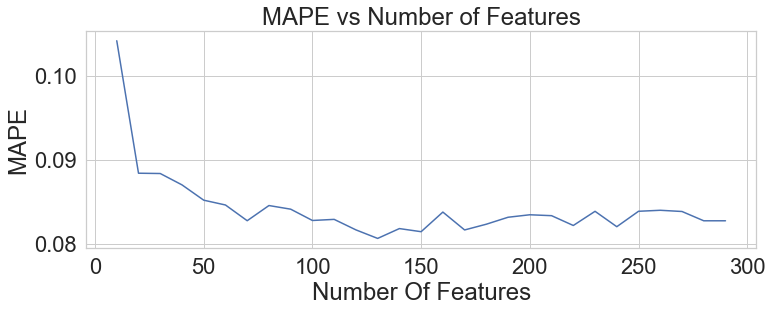

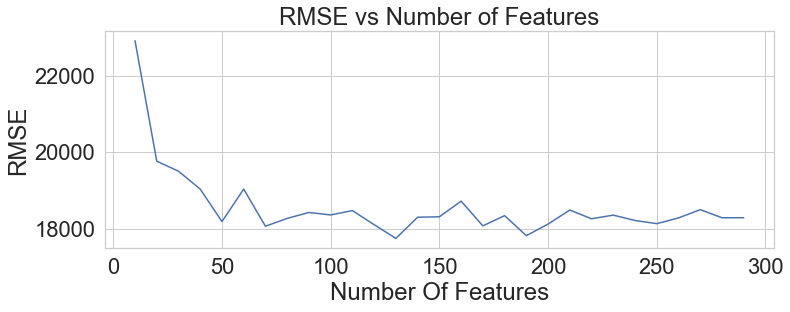

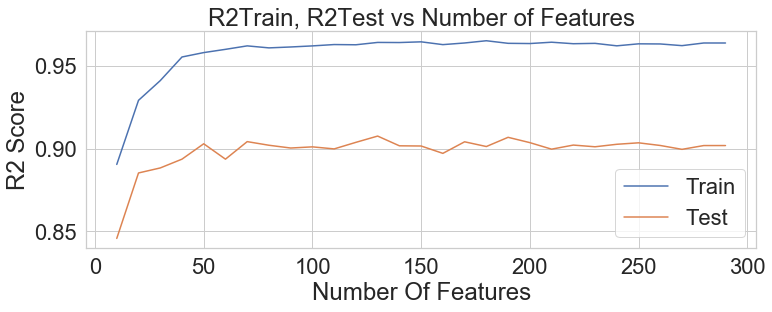

In [60]:
#annotation source: https://jakevdp.github.io/PythonDataScienceHandbook/04.09-text-and-annotation.html

fig, ax = plt.subplots(figsize=(12, 4))
sns.lineplot(x=n_feat_list, y=mape_list)

plt.title('MAPE vs Number of Features')
plt.xlabel('Number Of Features')
plt.ylabel('MAPE')

plt.show()

fig, ax1 = plt.subplots(figsize=(12, 4))

sns.lineplot(x=n_feat_list, y=mse_list)
plt.title('RMSE vs Number of Features')

plt.xlabel('Number Of Features')
plt.ylabel('RMSE')
plt.show()

fig, ax2 = plt.subplots(figsize=(12, 4))

sns.lineplot(x=n_feat_list, y=R2Train_list)
sns.lineplot(x=n_feat_list, y=R2Test_list)
plt.legend(['Train', 'Test'])
plt.title('R2Train, R2Test vs Number of Features')
plt.xlabel('Number Of Features')
plt.ylabel('R2 Score')

plt.show()



The plot below demonstrated that the cross validated model uses lower feature numbers for increased accuracy. However, more testing would need to be done to determine the exact number of optimized features, though the results indicate that the number would be around 90. 

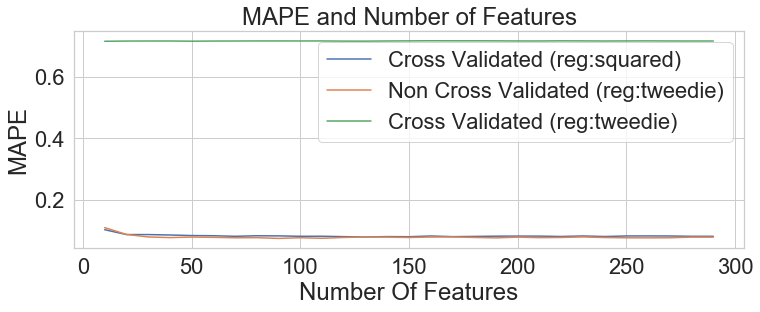

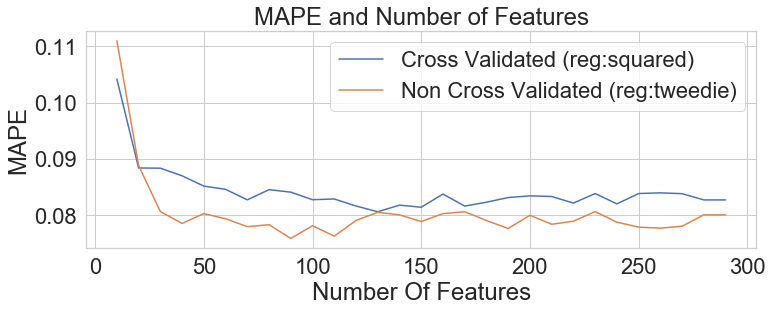

In [61]:
fig, ax2 = plt.subplots(figsize=(12, 4))

sns.lineplot(x=n_feat_list, y=mape_list)
sns.lineplot(x=n_feat_list, y=mape_list_inp)
sns.lineplot(x=n_feat_list, y=mape_list_dist)
plt.legend(['Cross Validated (reg:squared)', 'Non Cross Validated (reg:tweedie)', 'Cross Validated (reg:tweedie)'])
plt.title('MAPE and Number of Features')
plt.xlabel('Number Of Features')
plt.ylabel('MAPE')

plt.show()

fig, ax2 = plt.subplots(figsize=(12, 4))

sns.lineplot(x=n_feat_list, y=mape_list)
sns.lineplot(x=n_feat_list, y=mape_list_inp)
plt.legend(['Cross Validated (reg:squared)', 'Non Cross Validated (reg:tweedie)'])
plt.title('MAPE and Number of Features')
plt.xlabel('Number Of Features')
plt.ylabel('MAPE')

plt.show()


### Model 2: Feedforward Neural Network

In [62]:
dummies = pd.get_dummies(ProcessedTrainData)
train_x = dummies[[x for x in dummies.columns if x != 'SalePrice']]
train_y = ProcessedTrainData[['SalePrice']]
train_x = train_x.astype('float32')
train_y = train_y.astype('float32')
   
Train_Data_interim = train_x.iloc[:1000]
Test_Data_interim = train_x.iloc[1000:]
Train_Labels_interim = train_y.iloc[:1000]
Test_Labels_interim = train_y.iloc[1000:]

Many, many, many configurations were tried, but the loops to try them were removed so that the notebook would run smoothly. 

In [63]:
model = Sequential()
model.add(Dense(256, input_dim=len(Train_Data_interim.columns), activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='linear'))

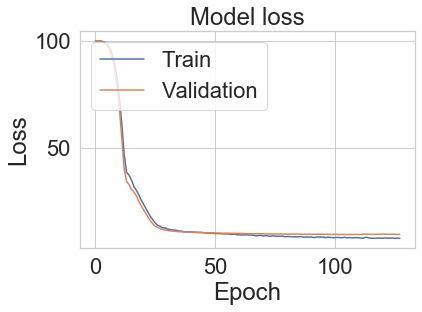

In [64]:
# compile the keras model
model.compile(loss='MAPE', optimizer='adamax', metrics=['MAPE'])

# fit the keras model on the dataset
history = model.fit(Train_Data_interim, Train_Labels_interim, epochs=128, batch_size=100, verbose=0, validation_split=0.2)#validation_data=(Test_Data_interim,Test_Labels_interim))#validation_split=0.33,

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [65]:
tempdf = pd.DataFrame(model.predict(Test_Data_interim), columns=['SalePrice'])
tempdf.index = Test_Labels_interim.index
error = (abs(tempdf-Test_Labels_interim)/Test_Labels_interim)
mape = error.sum()/len(Test_Labels_interim)
print(mape)

SalePrice    0.073405
dtype: float32


In [66]:
rmse = np.sqrt(np.mean((tempdf-Test_Labels_interim)**2))
print(rmse)

SalePrice    16286.469727
dtype: float32


In [67]:
rmsel = np.sqrt(np.mean(np.log((tempdf+1)/(Test_Labels_interim+1))**2))
print(rmsel)

SalePrice    0.09923
dtype: float32


In [68]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               77312     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 209,153
Trainable params: 209,153
Non-trainable params: 0
________________________________________________

### Model 3: Multiple Linear Regression

**Fit a model**

In [69]:
lm = LinearRegression()

**10 fold cross validation**

**features selected with PCA**

- populate data frame with performance data

In [70]:
# Features
Features = PCATrainData
# CV results
CVdf = []

# For each set of features
for f in range(len(Features)):
    # Append results to list
    df = pd.DataFrame(cross_validate(estimator=lm,
                       X=Features[f], y=train_y,
                       scoring=('r2', 'neg_mean_squared_error','neg_mean_absolute_error'),
                       return_train_score=True,
                       cv=10))
    CVdf.append(df)
CVdf = pd.concat(CVdf,axis=0).abs()
CVdf=CVdf.drop(columns=['fit_time', 'score_time','train_r2',
          'train_neg_mean_squared_error','train_neg_mean_absolute_error'])

- Make row entries

In [71]:
Xs = pd.DataFrame({"NoPCAs":PrincipalComponents})

> - Repeat 10x for each CV fold

In [72]:
Fs = Xs.iloc[np.repeat(np.arange(len(Xs)), 10)]

> - Reset indices

In [73]:
Fs.reset_index(drop=True, inplace=True)
CVdf.reset_index(drop=True, inplace=True)
CVdf = CVdf

- Concatenate

In [74]:
CVDF = pd.concat([Fs,CVdf],axis=1,sort=True)

- Contents

In [75]:
CVDF = CVDF[CVDF.test_r2<0.9]

In [76]:
CVDF.head()

NoPCAs   test_r2  test_neg_mean_squared_error  test_neg_mean_absolute_error
0       1  0.794094                 6.903622e+08                  19118.155524
1       1  0.781530                 8.229148e+08                  20501.990765
2       1  0.773972                 9.202266e+08                  23155.409836
3       1  0.598637                 1.387111e+09                  21875.677626
4       1  0.745742                 8.746942e+08                  21912.812434

Visualize performance

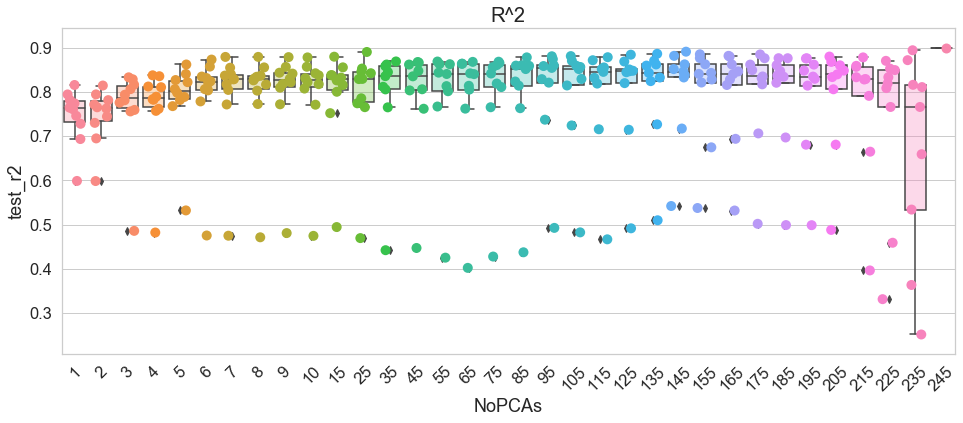

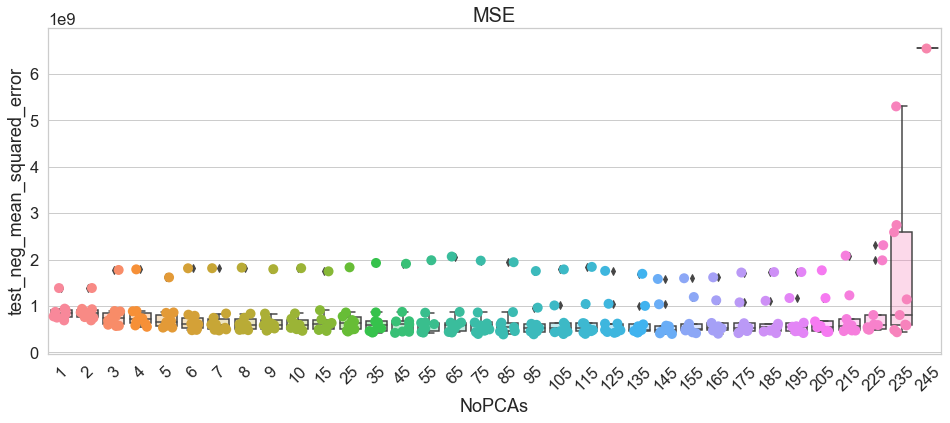

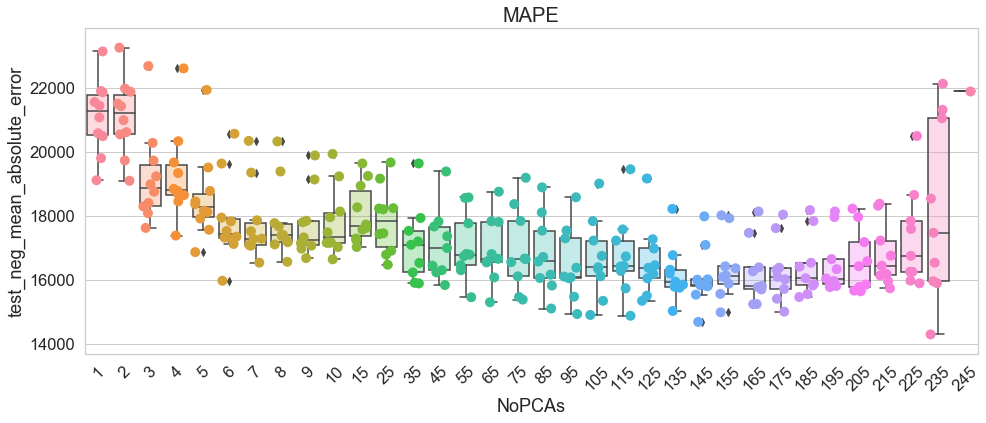

In [77]:
# Plot titles
titles = ["R^2","MSE","MAPE"]

# For each feature set
for c in range(1,len(CVDF.columns)):
    
    # Set style
    sns.set(style="whitegrid",
            color_codes=True,
            font_scale = 1.5)

    # Figure size
    plt.figure(figsize=(16, 6))

    # Title
    plt.title(titles[c-1], fontsize=20)

    # Boxplot
    p = sns.boxplot(x = 'NoPCAs',
                y = CVDF.iloc[:,c], 
                saturation=1,
                data=CVDF)

    # Reduce opacity
    for patch in p.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .3))

    # Add jittered observations
    p = sns.stripplot(x = 'NoPCAs',
                  y = CVDF.iloc[:,c],
                  data=CVDF,
                  jitter=0.3, size=10)

    # Rotate x-axis labels
    p.set_xticklabels(p.get_xticklabels(),
                  rotation=45);

Pick "best model"

- by $R^2$

In [78]:
CVDF[CVDF.test_r2 == np.amax(CVDF.test_r2)]

NoPCAs   test_r2  test_neg_mean_squared_error  \
333     245  0.899484                 6.564613e+09   

     test_neg_mean_absolute_error  
333                  21921.267908

- by MSE

In [79]:
CVDF[CVDF.test_neg_mean_squared_error == np.amin(CVDF.test_neg_mean_squared_error)]

NoPCAs   test_r2  test_neg_mean_squared_error  \
177      85  0.859251                 3.879877e+08   

     test_neg_mean_absolute_error  
177                  15102.257021

- by MAPE

In [80]:
CVDF[CVDF.test_neg_mean_absolute_error == np.amin(CVDF.test_neg_mean_absolute_error)]

NoPCAs   test_r2  test_neg_mean_squared_error  \
329     235  0.893918                 4.347204e+08   

     test_neg_mean_absolute_error  
329                  14290.708781

**features selected with variance thresholds**

- populate dataframe with performance data

In [81]:
# Features
Features = HiVarTrainData
# CV results
CVdf = []

# For each set of features
for f in range(len(Features)):
    # Append results to list
    df = pd.DataFrame(cross_validate(estimator=lm,
                       X=Features[f], y=train_y,
                       scoring=('r2', 'neg_mean_squared_error','neg_mean_absolute_error'),
                       return_train_score=True,
                       cv=10))
    CVdf.append(df)
CVdf = pd.concat(CVdf,axis=0).abs()
CVdf=CVdf.drop(columns=['fit_time', 'score_time','train_r2',
          'train_neg_mean_squared_error','train_neg_mean_absolute_error'])

- Make row entries

In [82]:
Xs = pd.DataFrame({"Variances":Variances})

> - Repeat 10x for each CV fold

In [83]:
Fs = Xs.iloc[np.repeat(np.arange(len(Xs)), 10)]

> - Reset indices

In [84]:
Fs.reset_index(drop=True, inplace=True)
CVdf.reset_index(drop=True, inplace=True)
CVdf = CVdf

- Concatenate

In [85]:
CVDF = pd.concat([Fs,CVdf],axis=1,sort=True)

- Contents

In [86]:
CVDF.head()

Variances       test_r2  test_neg_mean_squared_error  \
0        0.0  8.635061e+17                 2.895162e+27   
1        0.0  5.841533e+17                 2.200343e+27   
2        0.0  2.144848e+17                 8.732298e+26   
3        0.0  3.116576e+17                 1.077088e+27   
4        0.0  1.575482e+18                 5.419952e+27   

   test_neg_mean_absolute_error  
0                  8.754560e+12  
1                  5.293807e+12  
2                  3.843229e+12  
3                  3.131096e+12  
4                  8.623837e+12

Visualize performance

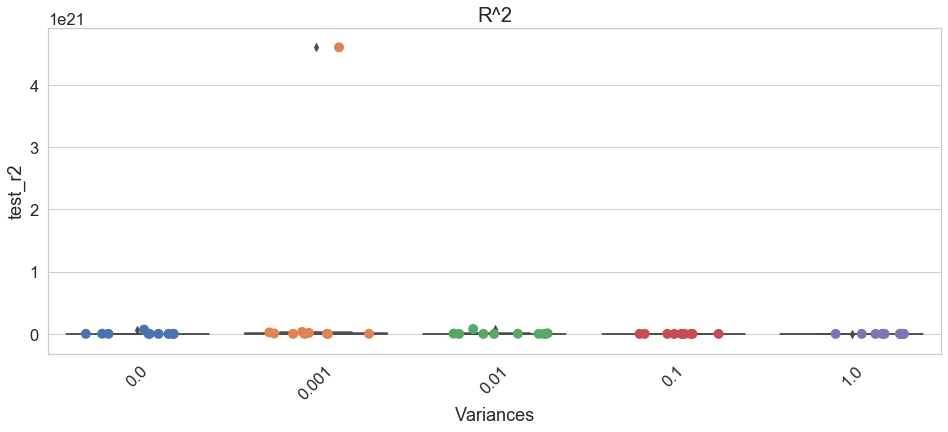

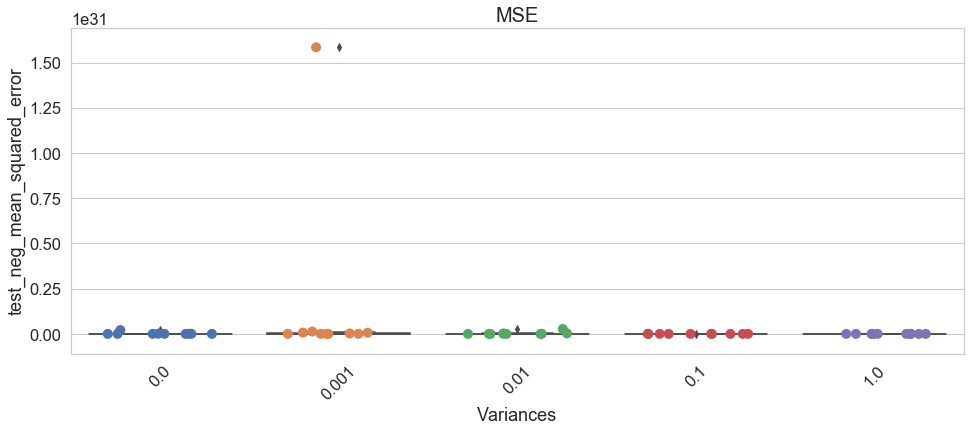

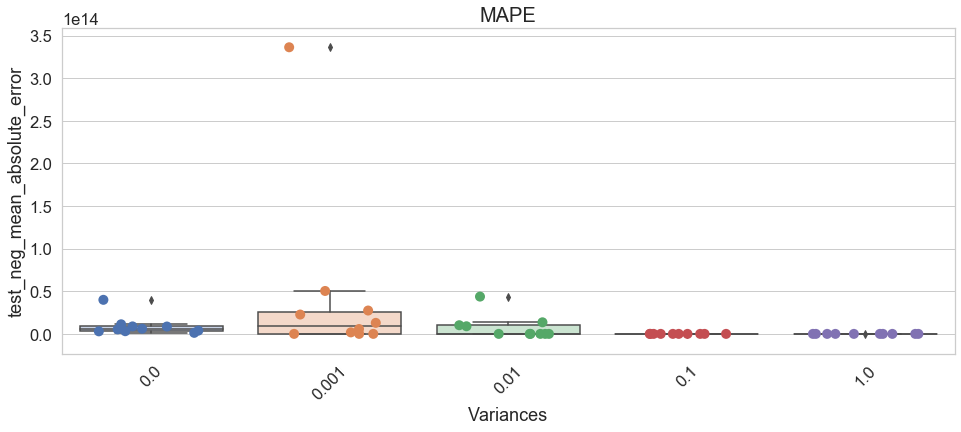

In [87]:
# Plot titles
titles = ["R^2","MSE","MAPE"]

# For each feature set
for c in range(1,len(CVDF.columns)):
    
    # Set style
    sns.set(style="whitegrid",
            color_codes=True,
            font_scale = 1.5)

    # Figure size
    plt.figure(figsize=(16, 6))

    # Title
    plt.title(titles[c-1], fontsize=20)

    # Boxplot
    p = sns.boxplot(x = 'Variances',
                y = CVDF.iloc[:,c], 
                saturation=1,
                data=CVDF)

    # Reduce opacity
    for patch in p.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .3))

    # Add jittered observations
    p = sns.stripplot(x = 'Variances',
                  y = CVDF.iloc[:,c],
                  data=CVDF,
                  jitter=0.3, size=10)

    # Rotate x-axis labels
    p.set_xticklabels(p.get_xticklabels(),
                  rotation=45);

Pick "best" features

- by $R^2$

In [88]:
CVDF[CVDF.test_r2 == np.amax(CVDF.test_r2)]

Variances       test_r2  test_neg_mean_squared_error  \
14      0.001  4.604833e+21                 1.584148e+31   

    test_neg_mean_absolute_error  
14                  3.363829e+14

- by MSE

In [89]:
CVDF[CVDF.test_neg_mean_squared_error == np.amin(CVDF.test_neg_mean_squared_error)]

Variances   test_r2  test_neg_mean_squared_error  \
39        0.1  0.916007                 3.442003e+08   

    test_neg_mean_absolute_error  
39                  14898.042939

- by MAPE

In [90]:
CVDF[CVDF.test_neg_mean_absolute_error == np.amin(CVDF.test_neg_mean_absolute_error)]

Variances   test_r2  test_neg_mean_squared_error  \
39        0.1  0.916007                 3.442003e+08   

    test_neg_mean_absolute_error  
39                  14898.042939

**features selected with RFE**

- populate dataframe with performance data

In [91]:
# Features
Features = RFETrainData
# CV results
CVdf = []

# For each set of features
for f in range(len(Features)):
    # Append results to list
    df = pd.DataFrame(cross_validate(estimator=lm,
                       X=Features[f], y=train_y,
                       scoring=('r2', 'neg_mean_squared_error','neg_mean_absolute_error'),
                       return_train_score=True,
                       cv=10))
    CVdf.append(df)
CVdf = pd.concat(CVdf,axis=0).abs()
CVdf=CVdf.drop(columns=['fit_time', 'score_time','train_r2',
          'train_neg_mean_squared_error','train_neg_mean_absolute_error'])

- Make row entries

In [92]:
Xs = pd.DataFrame({"NoFeatures":NumberOfFeatures})

> - Repeat 10x for each CV fold

In [93]:
Fs = Xs.iloc[np.repeat(np.arange(len(Xs)), 10)]

> - Reset indices

In [94]:
Fs.reset_index(drop=True, inplace=True)
CVdf.reset_index(drop=True, inplace=True)
CVdf = CVdf

- Concatenate

In [95]:
CVDF = pd.concat([Fs,CVdf],axis=1,sort=True)

- Contents

In [96]:
CVDF = CVDF[CVDF.test_r2<1]

In [97]:
CVDF.head()

NoFeatures   test_r2  test_neg_mean_squared_error  \
0           1  0.090677                 3.048777e+09   
1           1  0.022834                 3.680712e+09   
2           1  0.015391                 4.008628e+09   
3           1  0.000701                 3.458420e+09   
4           1  0.056946                 3.244281e+09   

   test_neg_mean_absolute_error  
0                  43388.892191  
1                  48107.935833  
2                  50287.349252  
3                  48809.691337  
4                  44478.951661

Visualize performance

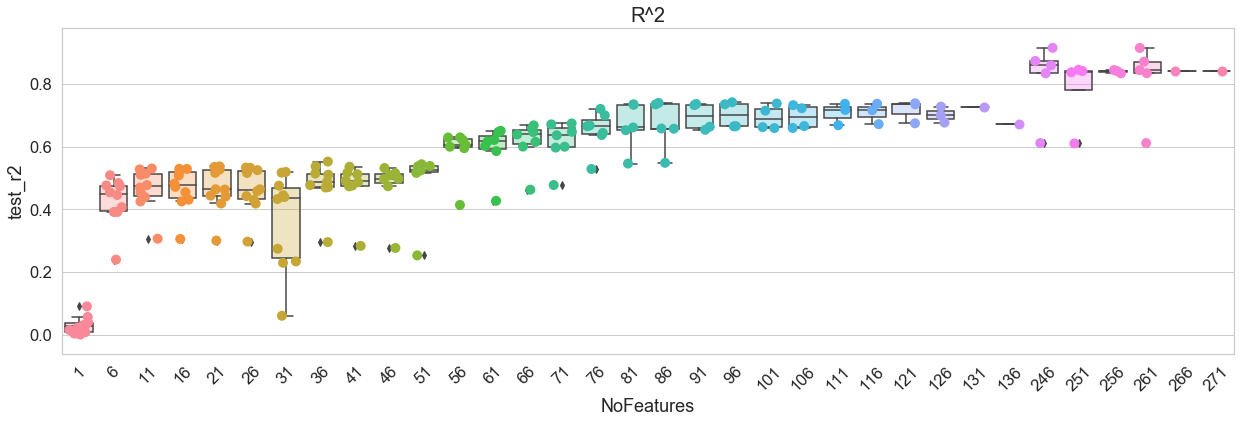

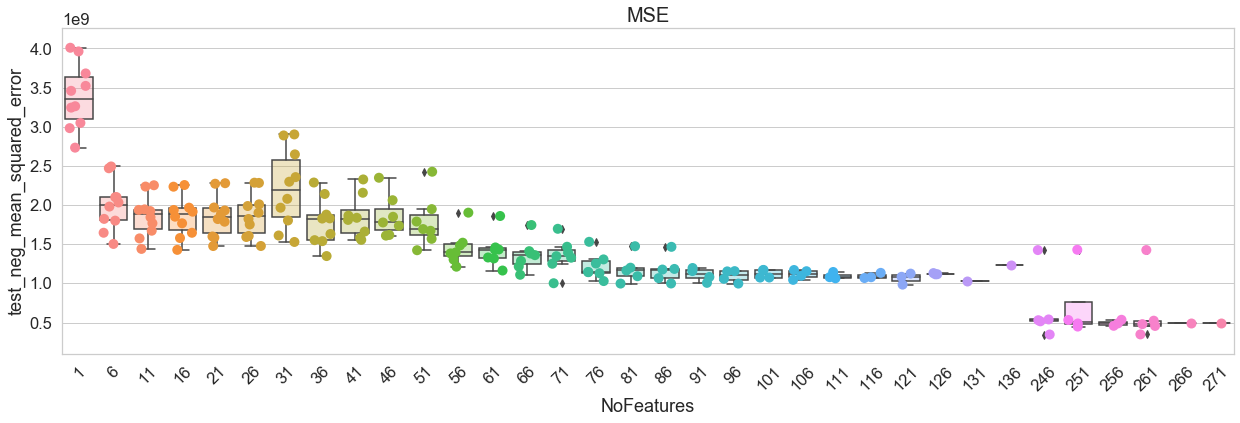

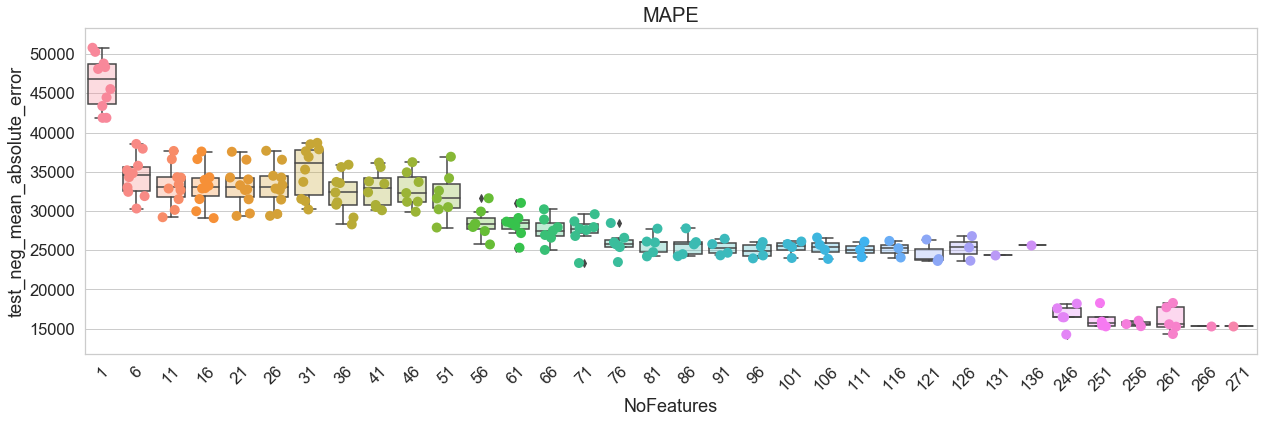

In [98]:
# Plot titles
titles = ["R^2","MSE","MAPE"]

# For each feature set
for c in range(1,len(CVDF.columns)):
    
    # Set style
    sns.set(style="whitegrid",
            color_codes=True,
            font_scale = 1.5)

    # Figure size
    plt.figure(figsize=(21, 6))

    # Title
    plt.title(titles[c-1], fontsize=20)

    # Boxplot
    p = sns.boxplot(x = 'NoFeatures',
                y = CVDF.iloc[:,c], 
                saturation=1,
                data=CVDF)

    # Reduce opacity
    for patch in p.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .3))

    # Add jittered observations
    p = sns.stripplot(x = 'NoFeatures',
                  y = CVDF.iloc[:,c],
                  data=CVDF,
                  jitter=0.3, size=10)

    # Rotate x-axis labels
    p.set_xticklabels(p.get_xticklabels(),
                  rotation=45);

Pick the "best" features

- by $R^2$

In [99]:
CVDF[CVDF.test_r2 == np.amax(CVDF.test_r2)]

NoFeatures   test_r2  test_neg_mean_squared_error  \
499         246  0.915258                 3.472712e+08   

     test_neg_mean_absolute_error  
499                  14263.280815

- by MSE

In [100]:
CVDF[CVDF.test_neg_mean_squared_error == np.amin(CVDF.test_neg_mean_squared_error)]

NoFeatures   test_r2  test_neg_mean_squared_error  \
499         246  0.915258                 3.472712e+08   

     test_neg_mean_absolute_error  
499                  14263.280815

- by MAPE

In [101]:
CVDF[CVDF.test_neg_mean_absolute_error == np.amin(CVDF.test_neg_mean_absolute_error)]

NoFeatures   test_r2  test_neg_mean_squared_error  \
499         246  0.915258                 3.472712e+08   

     test_neg_mean_absolute_error  
499                  14263.280815

**features selected with correlation thresholds**

populate dataframe with performance data

In [102]:
# Features
Features = CorrTrainData
# CV results
CVdf = []

# For each set of features
for f in range(len(Features)):
    # Append results to list
    df = pd.DataFrame(cross_validate(estimator=lm,
                       X=Features[f], y=train_y,
                       scoring=('r2', 'neg_mean_squared_error','neg_mean_absolute_error'),
                       return_train_score=True,
                       cv=10))
    CVdf.append(df)
CVdf = pd.concat(CVdf,axis=0).abs()
CVdf=CVdf.drop(columns=['fit_time', 'score_time','train_r2',
          'train_neg_mean_squared_error','train_neg_mean_absolute_error'])

- Make row entries

In [103]:
Xs = pd.DataFrame({"CorrThreshold":Corrs})

> - Repeat 10x for each CV fold

In [104]:
Fs = Xs.iloc[np.repeat(np.arange(len(Xs)), 10)]

> - Reset indices

In [105]:
Fs.reset_index(drop=True, inplace=True)
CVdf.reset_index(drop=True, inplace=True)
CVdf = CVdf

- Concatenate

In [106]:
CVDF = pd.concat([Fs,CVdf],axis=1,sort=True)

- Contents

In [107]:
CVDF.head()

CorrThreshold   test_r2  test_neg_mean_squared_error  \
0            0.1  0.129502                 2.918606e+09   
1            0.1  0.096087                 3.404790e+09   
2            0.1  0.084653                 3.726642e+09   
3            0.1  0.062780                 3.672964e+09   
4            0.1  0.030367                 3.335717e+09   

   test_neg_mean_absolute_error  
0                  42489.167335  
1                  47000.566273  
2                  49885.197162  
3                  47191.383699  
4                  45659.001088

Visualize data

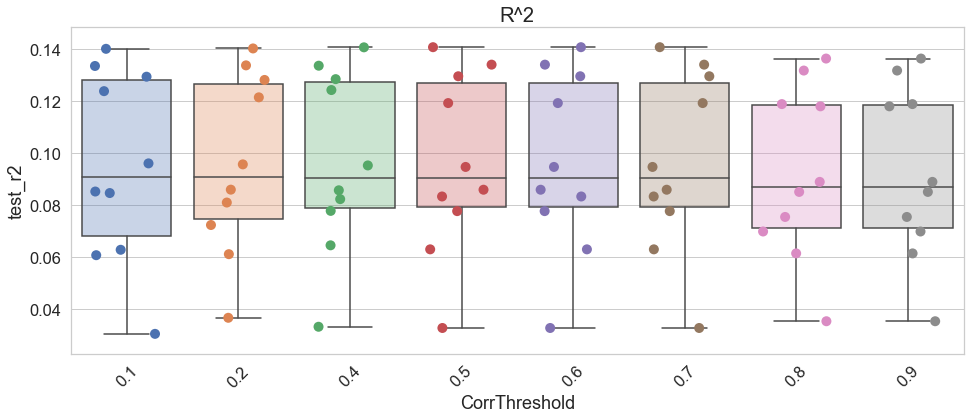

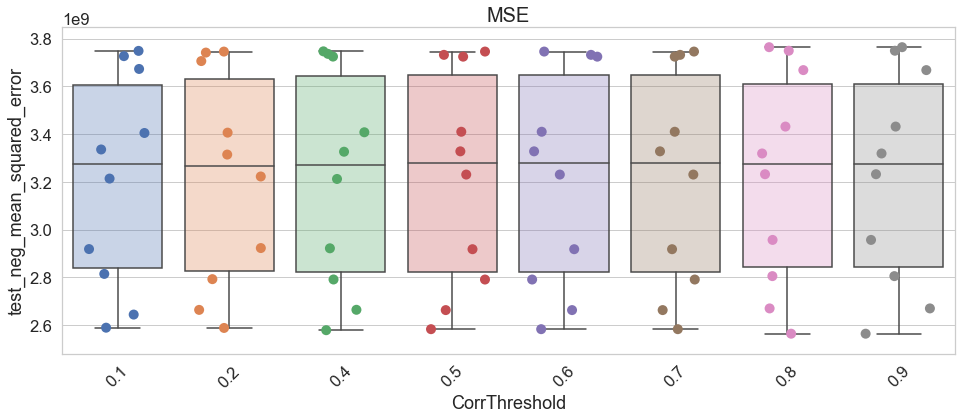

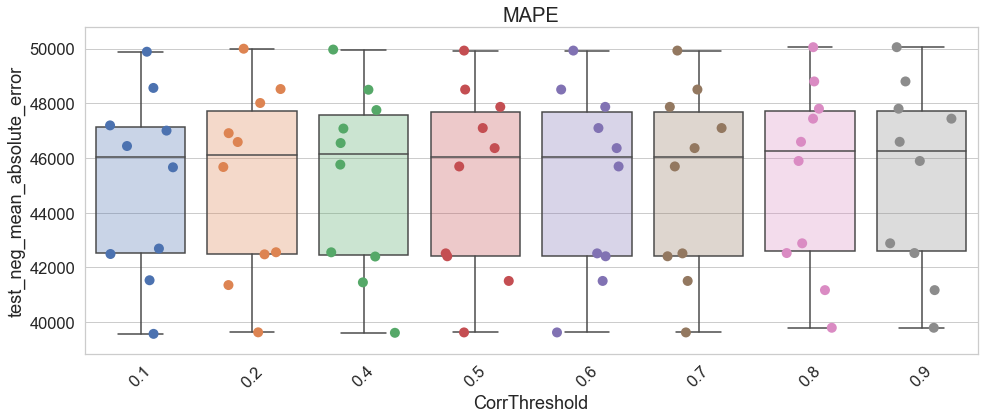

In [108]:
# Plot titles
titles = ["R^2","MSE","MAPE"]

# For each feature set
for c in range(1,len(CVDF.columns)):
    
    # Set style
    sns.set(style="whitegrid",
            color_codes=True,
            font_scale = 1.5)

    # Figure size
    plt.figure(figsize=(16, 6))

    # Title
    plt.title(titles[c-1], fontsize=20)

    # Boxplot
    p = sns.boxplot(x = 'CorrThreshold',
                y = CVDF.iloc[:,c], 
                saturation=1,
                data=CVDF)

    # Reduce opacity
    for patch in p.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .3))

    # Add jittered observations
    p = sns.stripplot(x = 'CorrThreshold',
                  y = CVDF.iloc[:,c],
                  data=CVDF,
                  jitter=0.3, size=10)

    # Rotate x-axis labels
    p.set_xticklabels(p.get_xticklabels(),
                  rotation=45);

Pick the "best" features

- by $R^2$

In [109]:
CVDF[CVDF.test_r2 == np.amax(CVDF.test_r2)]

CorrThreshold   test_r2  test_neg_mean_squared_error  \
38            0.5  0.140882                 2.790992e+09   
48            0.6  0.140882                 2.790992e+09   
58            0.7  0.140882                 2.790992e+09   

    test_neg_mean_absolute_error  
38                  42405.976242  
48                  42405.976242  
58                  42405.976242

- by MSE

In [110]:
CVDF[CVDF.test_neg_mean_squared_error == np.amin(CVDF.test_neg_mean_squared_error)]

CorrThreshold   test_r2  test_neg_mean_squared_error  \
67            0.8  0.069831                 2.564102e+09   
77            0.9  0.069831                 2.564102e+09   

    test_neg_mean_absolute_error  
67                  41168.410584  
77                  41168.410584

- by MAPE

In [111]:
CVDF[CVDF.test_neg_mean_absolute_error == np.amin(CVDF.test_neg_mean_absolute_error)]

CorrThreshold   test_r2  test_neg_mean_squared_error  \
5            0.1  0.140249                 2.644215e+09   

   test_neg_mean_absolute_error  
5                  39569.201671

**The choosen one- the model with the "best" features**

Define features

In [112]:
train_X_LM = train_x[RFETrainData[1].columns]

- Sanity check

In [113]:
train_X_LM.columns == RFETrainData[1].columns

array([ True,  True,  True,  True,  True,  True])

Build linear model object

In [114]:
lm = LinearRegression()

Fit model and cross validate

In [115]:
lmCV = cross_validate(estimator=lm,
                       X=train_X_LM, y=train_y,
                       scoring=('r2', 'neg_mean_squared_error','neg_mean_absolute_error'),
                       return_train_score=True,
                       cv=10)

- Train $R^2$

In [116]:
np.amax(lmCV['train_r2'])

0.4560712852996641

- Test $R^2$

In [117]:
np.amax(lmCV['test_r2'])

0.5089038703234917

- Train RMSE

In [118]:
abs(np.amin(lmCV['train_neg_mean_squared_error']))**0.5

45038.439759831825

- Test RMSE

In [119]:
abs(np.amin(lmCV['test_neg_mean_squared_error']))**0.5

49928.599259342336

- Train MAPE

> - predictions

In [120]:
y_pred = cross_val_predict(lm,
                             X=train_X_LM, y=train_y,
                             cv=10)

- Compute MAPE

In [121]:
def MAPE(y_true, y_pred): 
    # Define true vs predicted values
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Return the absolute distance between the true value and the predicted value
    return np.mean(np.abs((y_true - y_pred) / y_true))

In [122]:
MAPE(train_y, y_pred)

0.22751512

- LM coefficients, $t$-values, standard errors, and $p$-values

> - Add intercept

In [123]:
X = sm.add_constant(train_X_LM)

C:\Users\George\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


> - Build model

In [124]:
model = sm.OLS(train_y, X).fit()

> - Predictions

In [125]:
predictions = model.predict(X)

> - Summary 

In [126]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.435
Method:                 Least Squares   F-statistic:                     216.0
Date:                Fri, 13 Dec 2019   Prob (F-statistic):          9.77e-171
Time:                        11:39:50   Log-Likelihood:                -16957.
No. Observations:                1399   AIC:                         3.393e+04
Df Residuals:                    1393   BIC:                         3.396e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1.194e+05   3531.100     33.803      0.000    1.12e+05    1.26e+05
KitchenQual_Ex         1.038e+05   5029.593     20.645      0.000     9.4e+04    1.14e+05
KitchenQual_Fa        -3.058e+04   5879.947     -5.200      0.000   -4.21e+04    -1.9e+04
KitchenQual_Gd         5.393e+04   2720.269     19.826      0.000    4.86e+04    5.93e+04
KitchenQual_TA        -7831.9392   2497.660     -3.136      0.002   -1.27e+04   -2932.358
PavedDrive_Y           3.116e+04   4413.819      7.061      0.000    2.25e+04    3.98e+04
SaleCondition_Partial  1.426e+04   4962.445      2.873      0.004    4521.559     2.4e+04
==============================================================================
Omnibus:                       42.394   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               48.840
Skew:                           0.379   Prob(JB):                     2.48e-11
Kurtosis:                       3.513   Cond. No.                     3.22e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.12e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

**Ridge regression**

In [127]:
alphas = np.array([0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1])
# create and fit a ridge regression model, testing each alpha
model = Ridge()
grid = GridSearchCV(estimator=model,
                    param_grid=dict(alpha=alphas),
                    cv=10)
grid.fit(train_x, train_y)
# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_.alpha)

0.8079358668945376
1.0


C:\Users\George\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


## Model comparisons

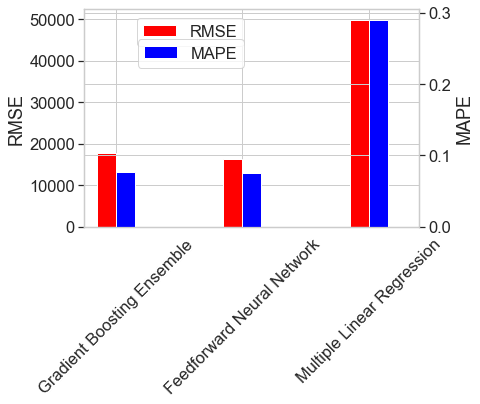

In [130]:
s = StringIO("""RMSE,MAPE
Gradient Boosting Ensemble,17909.719,0.07658489278079794
Feedforward Neural Network,16403.25,0.0749
Multiple Linear Regression,49903,0.29""")

df = pd.read_csv(s, index_col=0, delimiter=',', skipinitialspace=True)

fig = plt.figure() # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.15

df.RMSE.plot(kind='bar', color='red', ax=ax, width=width, position=1)
df.MAPE.plot(kind='bar', color='blue', ax=ax2, width=width, position=0)

ax.set_ylabel('RMSE')
ax2.set_ylabel('MAPE')

ax.legend(["RMSE"], bbox_to_anchor=(0.5,1.0))
ax2.legend(["MAPE"], bbox_to_anchor=(0.5,0.9))

for tick in ax.get_xticklabels():
    tick.set_rotation(45)

plt.show()

In the end, the best performing model was the feedforward neural network. It acheived a MAPE score that was ~0.15% lower than the gradient boosting ensemble. The RMSE was also very close but the NN, won by just ~1500.

## Conclusions

Given that our in our initial criteria we stressed the importance of explainability, we'd prefer to use the gradient boosting ensemble because it was just barely outperformed but it's easily interpretable.